This notebook contains code relating to section 5.4: multiclass bounding box segmentation. In particular, this is for the segmentation of 40-by-40-pixel patches.

# Installations

In [ ]:
pip -q install wandb

In [ ]:
pip -q install tensorflow_addons

In [ ]:
import numpy as np
import nibabel
import os
import tensorflow as tf
import matplotlib.pyplot as plt

import albumentations as A

from __future__ import print_function

from skimage.transform import resize
from skimage.io import imsave
from skimage.segmentation import mark_boundaries
from skimage.exposure import rescale_intensity
from skimage import io
from scipy.spatial.distance import directed_hausdorff

import keras
from keras.models import Model, Sequential
from tensorflow.keras.layers.experimental import preprocessing
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose, Dropout, BatchNormalization, Flatten, Dense
from tensorflow.keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras.callbacks import History
from tensorflow.keras.utils import plot_model
from tensorflow_addons.optimizers import AdamW
from tensorflow.keras import layers

import wandb
from wandb.keras import WandbCallback

from tqdm.auto import tqdm

os.getcwd()

'/content'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -q git+https://github.com/tensorflow/examples.git

from tensorflow_examples.models.pix2pix import pix2pix

In [ ]:
def get_tpu_strategy():
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver(
            tpu="grpc://" + os.environ["COLAB_TPU_ADDR"]
        )  # TPU detection
        print("Running on TPU ", tpu.cluster_spec().as_dict()["worker"])
    except ValueError:
        raise BaseException("ERROR: Not connected to a TPU runtime")

    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    return tf.distribute.TPUStrategy(tpu)

In [ ]:
tpu_strategy = get_tpu_strategy()

Running on TPU  ['10.53.244.194:8470']
INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.53.244.194:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.53.244.194:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [ ]:
# give permission to read data from google cloud bucket
from google.colab import auth
auth.authenticate_user()

Text(0, 0.5, 'Dice Coefficient')

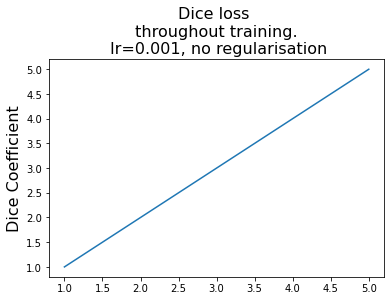

In [ ]:
plt.plot([1,5],[1,5])
plt.title('Dice loss \n throughout training. \n lr=0.001, no regularisation', size=16)
plt.ylabel('Dice Coefficient', size=16)

# Functions for loading data in TFRecords format

In [ ]:
def _parse_image_function(example_proto):

    """
    Reads from TFRecord file
    Returns a tf.train.Example object (can be read like a dictionary)
    """

    image_feature_description = {

        "image_raw": tf.io.FixedLenFeature([40 * 40], tf.float32),
        "mask_raw": tf.io.FixedLenFeature([40 * 40], tf.int64),
    }

    # Parse the input tf.train.Example proto using the dictionary above.
    return tf.io.parse_single_example(example_proto, image_feature_description)


def _unpack_proto(example_proto):

    """
    Extract image and mask from example_proto object
    """

    image = example_proto["image_raw"]
    image = tf.reshape(image, [40, 40, 1])

    mask = example_proto["mask_raw"]
    mask = tf.reshape(mask, [40, 40])

    return image, mask

In [ ]:
### Data Augmentation

def _unpack_proto_aug(example_proto):

    """
    Extract image and mask from example_proto object
    """

    image = example_proto["image_raw"]
    image = tf.reshape(image, [40, 40, 1])

    mask = example_proto["mask_raw"]
    mask = tf.reshape(mask, [40, 40])

    # DATA AUGMENTATION
    if tf.random.uniform(()) > 0.5:
      image = tf.image.flip_left_right(image)
      mask = tf.image.flip_left_right(tf.expand_dims(mask, [2]))
      mask = tf.squeeze(mask)

    if tf.random.uniform(()) > 0.5:
      image = tf.image.rot90(image)
      mask = tf.image.rot90(tf.expand_dims(mask, [2]))
      mask = tf.squeeze(mask)

    return image, mask


In [ ]:
def optimise_dataset(ds):

  """
  Improve performance of tensorflow dataset
  """

  ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
  # ds = ds.cache()
  return ds

def prepare_data(ds, shuffle=True):
  """
  Normalise, batch, shuffle and optimise the dataset
  """
  # ds = normalise(ds)
  if shuffle:
    ds = ds.shuffle(5000)
  batch_size = 8 * tpu_strategy.num_replicas_in_sync # 16*8 (tpu_strategy.num_replicas_in_sync value shown in output of previous cell)
  ds = ds.batch(batch_size, drop_remainder=True)
  ds = optimise_dataset(ds)
  return ds

def to_3_channels(image, mask):
  img_shape = (40, 40)
  image = tf.reshape(tf.repeat(image, 3), (*img_shape, 3))
  # mask = tf.reshape(tf.repeat(mask, 3), (*img_shape, 3))
  return image, mask

In [ ]:
def add_sample_weights(image, mask):
  # The weights for each class, with the constraint that:
  #     sum(class_weights) == 1.0
  class_weights = tf.constant([1.0, 10.0, 20.0])
  class_weights = class_weights/tf.reduce_sum(class_weights)

  # Create an image of `sample_weights` by using the label at each pixel as an 
  # index into the `class weights` .
  sample_weights = tf.gather(class_weights, indices=tf.cast(mask, tf.int32))

  return image, mask, sample_weights

# Load training and validation data

In [ ]:
train_nonempty_gcs_pattern = "gs://vascular_multiclass_method2_step2_40_ver2/train_non_empty*"
train_nonempty_filenames = tf.io.gfile.glob(train_nonempty_gcs_pattern)

train_nonempty_ds = tf.data.TFRecordDataset(train_nonempty_filenames)
train_nonempty_ds = train_nonempty_ds.map(_parse_image_function)
train_nonempty_ds = train_nonempty_ds.map(_unpack_proto_aug)
train_nonempty_ds = train_nonempty_ds.map(to_3_channels)

train_ds = prepare_data(train_nonempty_ds)
# train_ds = train_ds.map(add_sample_weights).element_spec

In [ ]:
for images, masks in train_ds.take(1):  # only take first element of dataset
      numpy_images = images.numpy()
      numpy_masks = masks.numpy()

numpy_images.shape, numpy_masks.shape

((64, 40, 40, 3), (64, 40, 40))

In [ ]:
val_nonempty_gcs_pattern = "gs://vascular_multiclass_method2_step2_40_ver2/val_non_empty*"
val_nonempty_filenames = tf.io.gfile.glob(val_nonempty_gcs_pattern)

val_nonempty_ds = tf.data.TFRecordDataset(val_nonempty_filenames)
val_nonempty_ds = val_nonempty_ds.map(_parse_image_function)
val_nonempty_ds = val_nonempty_ds.map(_unpack_proto)
val_nonempty_ds = val_nonempty_ds.map(to_3_channels)

val_ds = prepare_data(val_nonempty_ds.repeat())

In [ ]:
for images, masks in val_ds.take(1):  # only take first element of dataset
      numpy_images = images.numpy()
      numpy_masks = masks.numpy()

numpy_images.shape, numpy_masks.shape

((64, 40, 40, 3), (64, 40, 40))

# Display Images

In [ ]:
batch_num = 1
img_num = 5

for images, masks in val_ds.take(batch_num):  # only take first element of dataset
  numpy_images = images.numpy()
  numpy_masks = masks.numpy()

In [ ]:
test_mask = numpy_masks[30]
test_mask.shape

(40, 40)

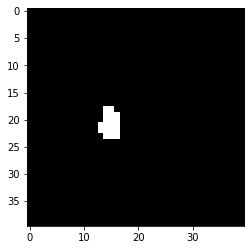

In [ ]:
plt.imshow(test_mask==2, cmap='gray')

Text(0.5, 1.0, 'Mask')

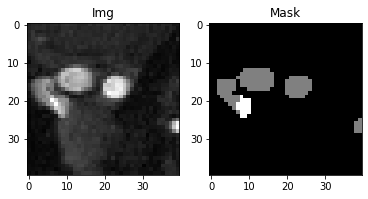

In [ ]:
img_num = 3

plt.subplot(1,2,1)
plt.imshow(numpy_images[img_num], cmap='gray')
plt.title('Img')

plt.subplot(1,2,2)
plt.imshow(numpy_masks[img_num], cmap='gray')
plt.title('Mask')

# Loss Function

In [ ]:
# return our metric and loss

with tpu_strategy.scope():

  def dice_coef(y_true, y_pred, smooth=1e-16):
    y_true_f = tf.cast(K.flatten(y_true), tf.float32)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)

    return (2* intersection + smooth)/(K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


  def dice_coef_multiclass(y_true, y_pred, output_channels=3):
    dice_tot = 0

    for index in range(0, output_channels): # calculate dice coefficient for classes 1 & 2 (aneurysms & vasculature, not background)
        dice_tot += dice_coef(y_true==index, y_pred[:,:,:,index])

    return dice_tot/(output_channels) # take average dice


  def dice_loss_multiclass(y_true, y_pred, output_channels=3):
    
    dice = dice_coef_multiclass(y_true, y_pred)

    return (1 - dice) # take average dice


  def dice_coef_loss(y_true, y_pred):
    return (1.0 - dice_coef(y_true, y_pred))


  def mixed_loss(y_true, y_pred):

    y_true_f = tf.cast(K.flatten(y_true), tf.float32)
    y_pred_f = K.flatten(y_pred)

    bce = tf.keras.losses.binary_crossentropy(y_true_f, y_pred_f, from_logits=True)
    dice = dice_coef(y_true, y_pred)

    return bce + (1.0 - dice)

# Model Architecture

## Pre-trained model: original

In [ ]:
def rescale_output(y_pred):

  y_pred = tf.clip_by_value(y_pred, clip_value_min=0., clip_value_max=1.) # force values to be between 0 and 2

  return y_pred

In [ ]:
with tpu_strategy.scope(): 

  def unet_model(output_channels):

    inputs = tf.keras.layers.Input(shape=[40, 40, 3])
    resize_layer = tf.keras.layers.Lambda(lambda img: tf.image.resize(img, (96, 96)))
    x = resize_layer(inputs)

    # Downsampling through the model
    base_model = tf.keras.applications.MobileNetV2(input_shape=[96, 96, 3], include_top=False) # ImageNet weights only work with 3 channel images

    # # adding regularization
    # penalty = 0.001
    # regularizer = tf.keras.regularizers.l2(penalty)

    # for layer in base_model.layers:
    #     for attr in ['kernel_regularizer']:
    #         if hasattr(layer, attr):
    #           setattr(layer, attr, regularizer)

    #  # When we change the layers attributes, the change only happens in the model config file
    # model_json = base_model.to_json()

    # # Save the weights before reloading the model.
    # weights_path = "/content/drive/My Drive/Masters Project/Vascular Segmentation/Model Weights/test5.h5"
    # # weights_path = os.path.join(weights_path, 'test1.h5')
    # base_model.save_weights(weights_path)

    # # load the model from the config
    # base_model = tf.keras.models.model_from_json(model_json)
    
    # # Reload the model weights
    # base_model.load_weights(weights_path, by_name=True)

    # Use the activations of these layers
    layer_names = [
        'block_1_expand_relu',   # 48x48
        'block_3_expand_relu',   # 24x24
        'block_6_expand_relu',   # 12x12
        'block_13_expand_relu',  # 6x6
        'block_16_project',      # 3x3
    ]
    base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

    # # Create the feature extraction model
    down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

    down_stack.trainable = False

    up_stack = [
        pix2pix.upsample(512, 3),  # 4x4 -> 8x8
        pix2pix.upsample(256, 3),  # 8x8 -> 16x16
        pix2pix.upsample(128, 3),  # 16x16 -> 32x32
        pix2pix.upsample(64, 3),   # 32x32 -> 64x64
    ]

    skips = down_stack(x)
    x = skips[-1] # final output of encoder
    skips = reversed(skips[:-1]) # all outputs of encoder except final, reversed
    # Upsampling and establishing the skip connections
    
    for up, skip in zip(up_stack, skips):
      x = up(x) # pass output of encoder through decoder (iterates through outputs of decoder)
      concat = tf.keras.layers.Concatenate() 
      x = concat([x, skip]) # cross-link: output of decoder concatenated with encoder output
    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
        output_channels, 3, strides=2,
        padding='same')  #64x64 -> 128x128

    normalise_output = tf.keras.layers.Lambda(rescale_output)

    x = last(x)
    shrinking_layer = tf.keras.layers.Lambda(lambda img: tf.image.resize(img, (40, 40)))
    x = shrinking_layer(x)
    # x = tf.keras.activations.softmax(x)
    # x = normalise_output(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

### Model Summary

In [ ]:
model.summary()

NameError: ignored

# Load top-performing model

In [ ]:
model = keras.models.load_model("/content/drive/My Drive/Masters Project/Vascular Segmentation/Model Weights/Vessel seg 40/lr=1e-3.4_l2(0.001).h5", custom_objects={'dice_loss_multiclass': dice_loss_multiclass, 'dice_coef_multiclass': dice_coef_multiclass})

# Find Optimal Learning Rate

In [ ]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = dice_coef_multiclass

model = unet_model(output_channels=3)
model.compile(optimizer=Adam(), loss=loss, metrics=metrics)

initial_weights = model.get_weights()
len(initial_weights)

KeyboardInterrupt: ignored

In [ ]:
def find_learning_rate(num_rates=50):
    rates = np.logspace(-5, -1, num=num_rates)
    img, label = list(train_ds.take(1))[0]
    losses = []
    for rate in tqdm(rates):

          model.compile(optimizer=Adam(learning_rate=rate), loss=loss, metrics=metrics)
          model.set_weights(initial_weights)
          model.fit(img, label, epochs=5, verbose=0)
          losses.append(model.history.history['loss'][-1])
    return losses, rates

losses, rates = find_learning_rate(50)

In [ ]:
plt.plot(np.log10(rates), np.clip(losses, 0, 2))
plt.title('Sparse categorical \n cross-entropy loss \n for a variety of learning rates', size=16)
plt.xlabel('\n Learning rate exponent', size=16)
plt.ylabel('Sparse categorical \n cross-entropy loss \n', size=16)
plt.xticks(size=12)
plt.yticks(size=12)

# Learning Rate Scheduling & Early Stopping

In [ ]:
def build_learning_rate_cycler(
    lr_start=1e-5,
    lr_max=5e-5,
    lr_min=1e-6,
    lr_rampup_epochs=10,
    lr_sustain_epochs=2,
    lr_exp_decay=0.9,
):
    lr_max = lr_max

    def lrfn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) * lr_exp_decay ** (
                epoch - lr_rampup_epochs - lr_sustain_epochs
            ) + lr_min
        return lr

    return lrfn

lr_cycler = build_learning_rate_cycler(
          lr_start=1e-5,
          lr_max=1e-2,
          lr_min=1e-6,
          lr_rampup_epochs=20,
          lr_sustain_epochs=0,
          lr_exp_decay=0.9,
      )   

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
                    monitor='val_loss',
                    patience=20,
                    restore_best_weights=True,
                    mode='auto',
                )

# Training

In [ ]:
with tpu_strategy.scope():

  model = unet_model(output_channels=3) # 1 output channel per class (background, vessels, aneurysms)

  learning_rate = 10**(-3.4)
  # loss = dice_loss_multiclass
  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  metrics = dice_coef_multiclass

  model.compile(optimizer=Adam(learning_rate=learning_rate),
                loss=loss,
                metrics=metrics)

  EPOCHS = 200

# train on aneurysm-positive only
  history = model.fit(
      train_ds.map(add_sample_weights).repeat(),
      epochs=EPOCHS,
      steps_per_epoch=10,
      validation_data=val_ds.repeat(),
      validation_steps=1, callbacks = [early_stopping]) # , tf.keras.callbacks.LearningRateScheduler(lr_cycler, verbose=1)

  save_model_path = "/content/drive/My Drive/Masters Project/Vascular Segmentation/Model Weights/Vessel seg 40"
  model.save(os.path.join(save_model_path, 'lr=1e-3.4.h5'))

Epoch 1/200
10/10 [==============================] - 22s 672ms/step - loss: 0.0478 - dice_coef_multiclass: 0.0021 - val_loss: 0.5523 - val_dice_coef_multiclass: 0.2052
Epoch 2/200
10/10 [==============================] - 1s 144ms/step - loss: 0.0280 - dice_coef_multiclass: 0.3082 - val_loss: 0.3532 - val_dice_coef_multiclass: 0.2776
Epoch 3/200
10/10 [==============================] - 1s 139ms/step - loss: 0.0218 - dice_coef_multiclass: 0.3696 - val_loss: 0.2274 - val_dice_coef_multiclass: 0.3443
Epoch 4/200
10/10 [==============================] - 1s 144ms/step - loss: 0.0184 - dice_coef_multiclass: 0.4057 - val_loss: 0.1933 - val_dice_coef_multiclass: 0.3801
Epoch 5/200
10/10 [==============================] - 1s 131ms/step - loss: 0.0161 - dice_coef_multiclass: 0.4176 - val_loss: 0.1618 - val_dice_coef_multiclass: 0.3997
Epoch 6/200
10/10 [==============================] - 1s 145ms/step - loss: 0.0145 - dice_coef_multiclass: 0.4248 - val_loss: 0.1419 - val_dice_coef_multiclass: 0.41

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


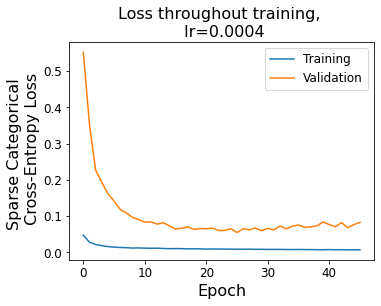

In [ ]:
plt.figure(figsize=(12, 4)) 

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.xlabel('Epoch', size=16)
plt.ylabel('Sparse Categorical \n Cross-Entropy Loss', size=16)
plt.xticks(size=12)
plt.yticks(size=12)
plt.title('Loss throughout training, \n lr={}'.format(np.round(learning_rate,5)), size=16)
plt.legend(prop={'size': 12})

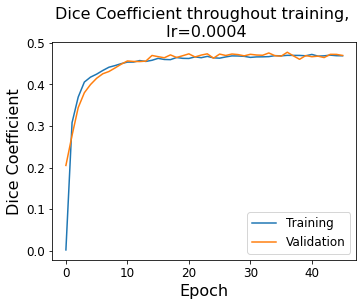

In [ ]:
plt.figure(figsize=(12, 4)) 

plt.subplot(1,2,2)
plt.plot(history.history['dice_coef_multiclass'], label='Training')
plt.plot(history.history['val_dice_coef_multiclass'], label='Validation')
plt.xlabel('Epoch', size=16)
plt.ylabel('Dice Coefficient', size=16)
plt.xticks(size=12)
plt.yticks(size=12)
plt.title('Dice Coefficient throughout training, \n lr={}'.format(np.round(learning_rate,5)), size=16)
plt.legend(prop={'size': 12})

# Predict on single test image

In [ ]:
test_nonempty_gcs_pattern = "gs://vascular_multiclass_method2_step2_40_ver2/test_non_empty*"
test_nonempty_filenames = tf.io.gfile.glob(test_nonempty_gcs_pattern)

test_nonempty_ds = tf.data.TFRecordDataset(test_nonempty_filenames)
test_nonempty_ds = test_nonempty_ds.map(_parse_image_function)
test_nonempty_ds = test_nonempty_ds.map(_unpack_proto)
test_nonempty_ds = test_nonempty_ds.map(to_3_channels)

test_ds = prepare_data(test_nonempty_ds)

In [ ]:
test_images = []
test_masks = []

for batch_num in range(4):
  for images, masks in test_ds.take(batch_num):  
        numpy_images = images.numpy()
        numpy_masks = masks.numpy()

        test_images.append(numpy_images)
        test_masks.append(numpy_masks)

test_images = np.concatenate(test_images)
test_masks = np.concatenate(test_masks)

In [ ]:
test_images.shape, test_images[0].shape

((384, 40, 40, 3), (40, 40, 3))

Unique pixel values in predicted mask: [0 1 2]


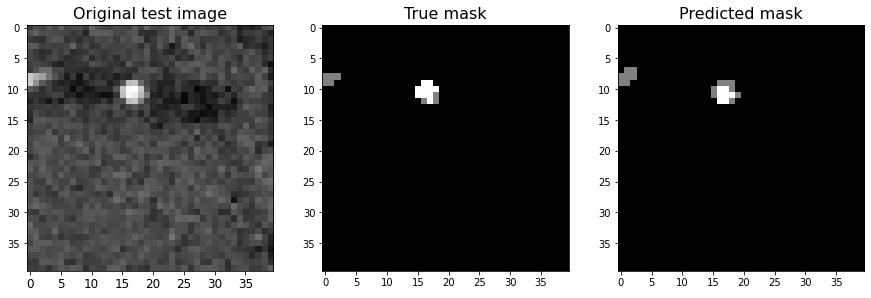

In [ ]:
plt.figure(figsize=(15, 5)) 

img_num = 26

plt.subplot(1,3,1)
plt.imshow(test_images[img_num])
plt.title('Original test image', size=16)
plt.xticks(size=12)

plt.subplot(1,3,2)
plt.imshow(test_masks[img_num], cmap='gray')
plt.title('True mask', size=16)

pred_mask = model.predict(tf.expand_dims(test_images[img_num], axis=[0]))
pred_mask = tf.argmax(pred_mask, axis=-1)[0]

plt.subplot(1,3,3)
plt.imshow(pred_mask, cmap='gray')
plt.title('Predicted mask', size=16)

print('Unique pixel values in predicted mask: {}'.format(np.unique(np.round(pred_mask))))

In [ ]:
pred_mask.shape

TensorShape([40, 40])

# Evaluate on whole test set

In [ ]:
print('Predicting masks on test data...')
test_preds = [tf.argmax(model.predict(tf.expand_dims(image, axis=[0])), axis=-1)[0] for image in test_images]

Predicting masks on test data...


In [ ]:
len(test_preds), test_preds[0].shape

(384, TensorShape([40, 40]))

In [ ]:
def compare_img_mask(img_num):

  """
  Display original image with mask, true mask and predicted mask for a specified image number
  
  Args:
  train_, test_ or valid_ + images/masks/preds
  """
  
  plt.figure(figsize=(20, 4)) 

  plt.subplot(1,3,1)
  plt.imshow(test_images[img_num])
  plt.title('Original image patch', size=16)

  plt.subplot(1,3,2)
  plt.imshow(test_masks[img_num], cmap='gray')
  plt.title('True mask (40 x 40)', size=16)

  plt.subplot(1,3,3)
  plt.imshow(test_preds[img_num], cmap='gray')
  plt.title('Predicted mask (40 x 40)', size=16)

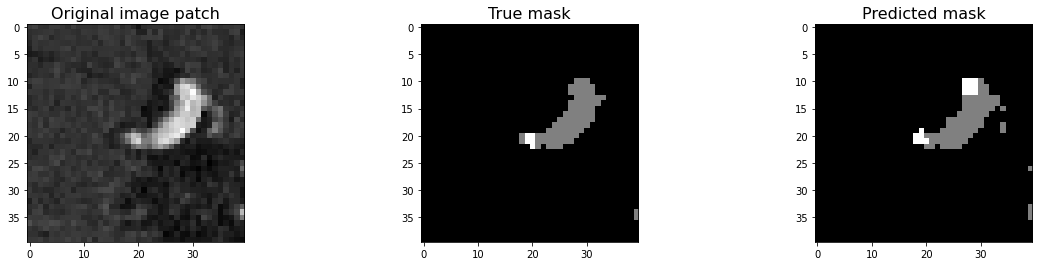

In [ ]:
compare_img_mask(0)

## Dice Coefficient: Aneurysms & vessels

In [ ]:
def test_dice_multiclass(y_true, y_pred, output_channels, smooth=1e-15):
  dice_tot = 0

  for index in range(1, output_channels): # calculate dice coefficient for classes 1 & 2 (aneurysms & vasculature, not background)

        intersection = np.sum((y_true==index) * (y_pred==index))

        num = (2* intersection + smooth)

        denom = (np.sum(y_true==index) + np.sum(y_pred==index) + smooth)

        dice_tot += num/denom

  return dice_tot/(output_channels-1) # take average dice

In [ ]:
# calculate dice coeff for each pair of true (test_masks) and predicted (test_preds) masks in the test set

dice_coeff_list = []
dice_coeff_dict = {}

for i in range(len(test_masks)):
  true_mask = test_masks[i]
  pred_mask = test_preds[i]
  a = tf.make_tensor_proto(pred_mask)
  pred_mask = tf.make_ndarray(a)

  dice_coeff = test_dice_multiclass(true_mask, pred_mask, 3)
  dice_coeff = np.array(dice_coeff)
  dice_coeff_list.append(dice_coeff)
  dice_coeff_dict[i] = dice_coeff

np.mean(dice_coeff_list), np.std(dice_coeff_list)

(0.42435981003584516, 0.2150623288015588)

(0.0, 200.0)

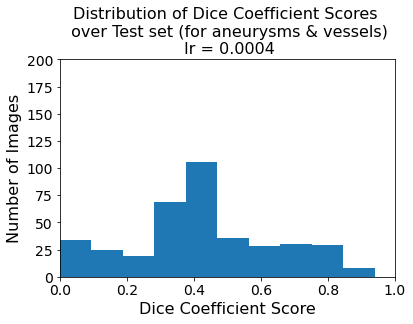

In [ ]:
plt.hist(dice_coeff_list)
plt.title('Distribution of Dice Coefficient Scores \n over Test set (for aneurysms & vessels)\n lr = {}'.format(np.round(learning_rate,5)), size=16)
plt.xlabel('Dice Coefficient Score', size=16)
plt.ylabel('Number of Images', size=16)
plt.xticks(size=14)
plt.yticks(size=14)

plt.xlim(0, 1)
plt.ylim(0, 200)

## Dice Coefficient: aneurysms only

In [ ]:
def test_dice_multiclass2(y_true, y_pred, output_channels, smooth=1e-15):
  dice_tot = 0

  index = 2

  intersection = np.sum((y_true==index) * (y_pred==index))

  num = (2* intersection + smooth)

  denom = (np.sum(y_true==index) + np.sum(y_pred==index) + smooth)

  dice_tot += num/denom

  return dice_tot# take average dice

In [ ]:
# calculate dice coeff for each pair of true (test_masks) and predicted (test_preds) masks in the test set

dice_coeff_list2 = []
dice_coeff_dict2 = {}

for i in range(len(test_masks)):
  true_mask = test_masks[i]
  pred_mask = test_preds[i]
  a = tf.make_tensor_proto(pred_mask)
  pred_mask = tf.make_ndarray(a)

  dice_coeff = test_dice_multiclass2(true_mask, pred_mask, 3)
  dice_coeff = np.array(dice_coeff)
  dice_coeff_list2.append(dice_coeff)
  dice_coeff_dict2[i] = dice_coeff

np.mean(dice_coeff_list2), np.std(dice_coeff_list2)

(0.31699367461507627, 0.3169468468097482)

(0.0, 300.0)

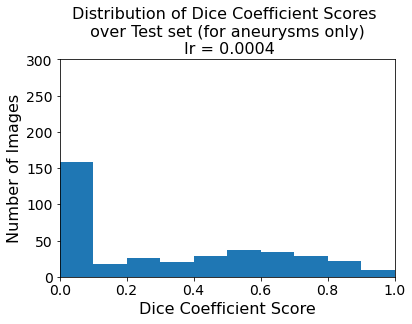

In [ ]:
plt.hist(dice_coeff_list2)
plt.title('Distribution of Dice Coefficient Scores \n over Test set (for aneurysms only) \n lr = {}'.format(np.round(learning_rate,5)), size=16)
plt.xlabel('Dice Coefficient Score', size=16)
plt.ylabel('Number of Images', size=16)
plt.xticks(size=14)
plt.yticks(size=14)

plt.xlim(0, 1)
plt.ylim(0, 300)

In [ ]:
# create lists 'low' and 'high' that store indices of low and high scoring masks respectively

low = []
med = []
high = []

for key,val in dice_coeff_dict.items():
  if val<0.3:
    low.append(key)
  elif val<0.7 and val>0.4:
    med.append(key)
  elif val>0.7:
    high.append(key)

len(low), len(med), len(high)

(85, 158, 56)

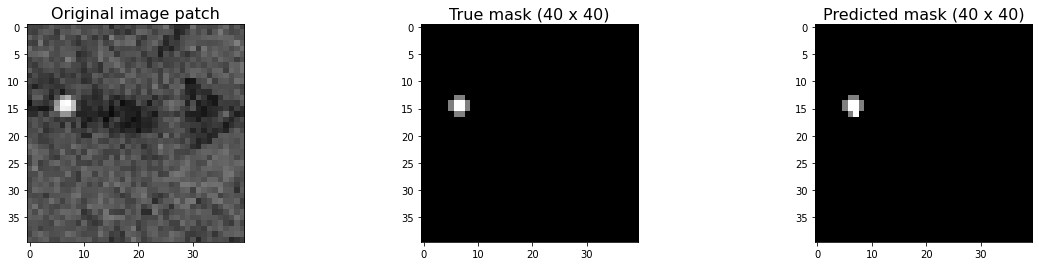

In [ ]:
compare_img_mask(29)

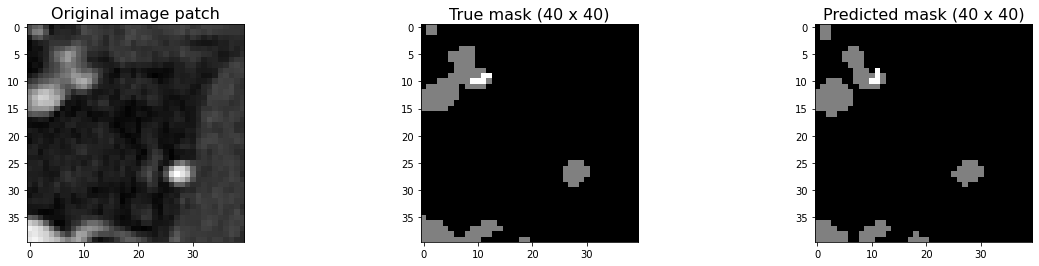

In [ ]:
compare_img_mask(72)

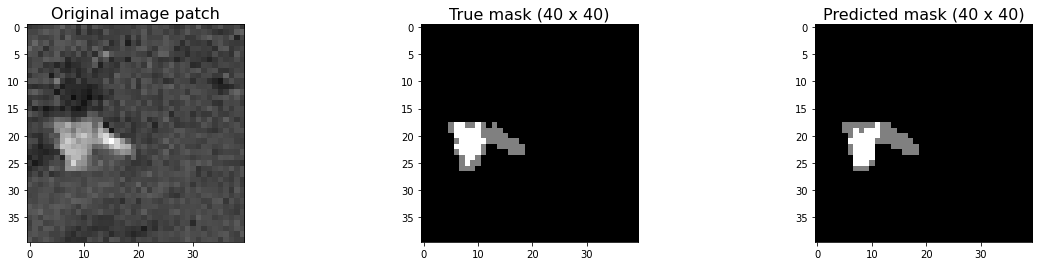

In [ ]:
compare_img_mask(196)

9


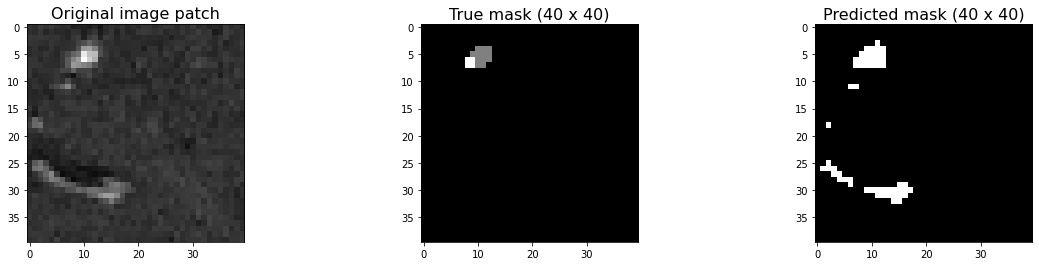

10


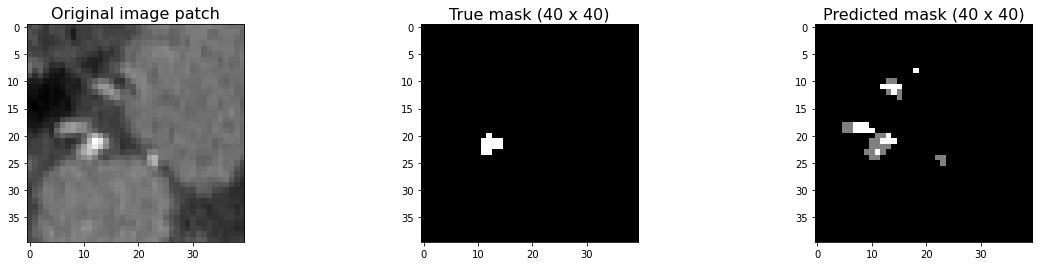

14


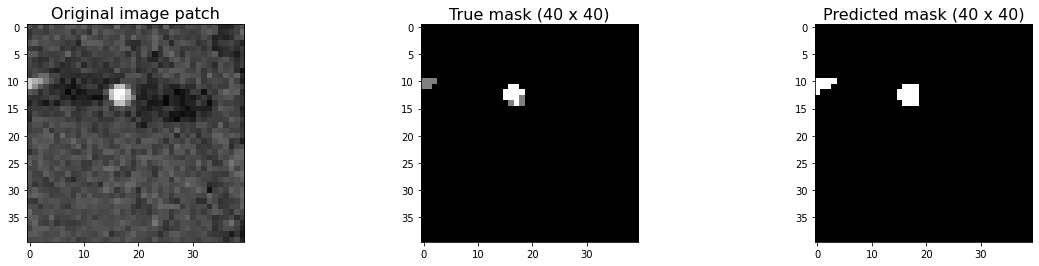

19


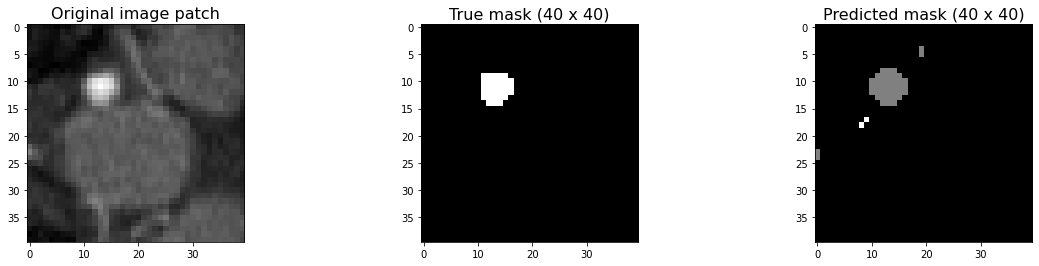

23


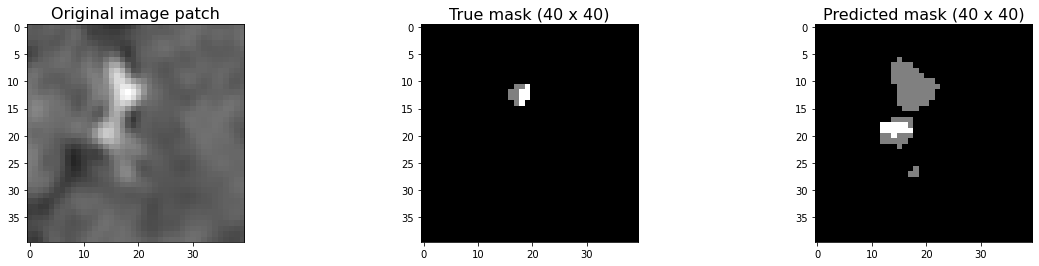

28


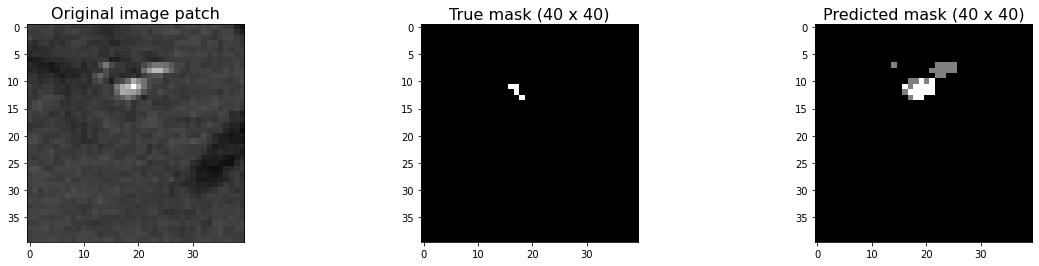

32


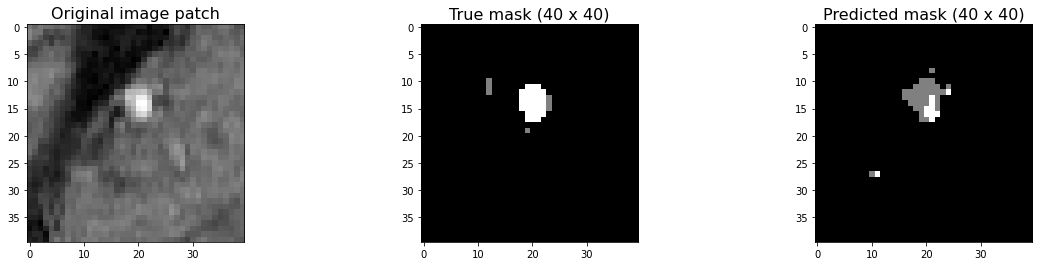

33


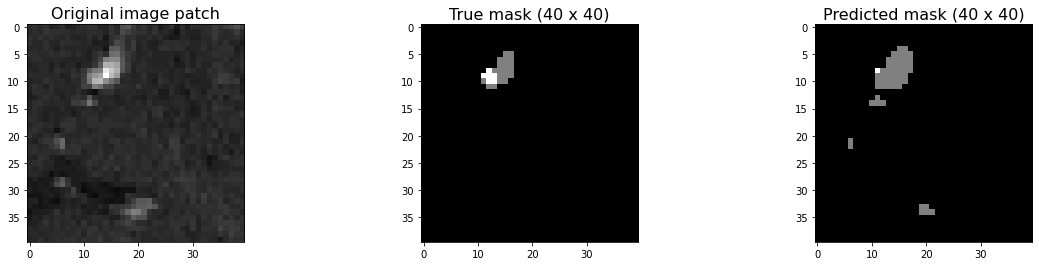

37


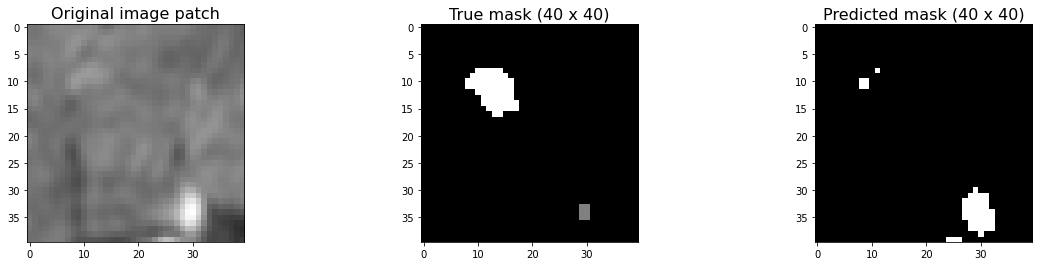

45


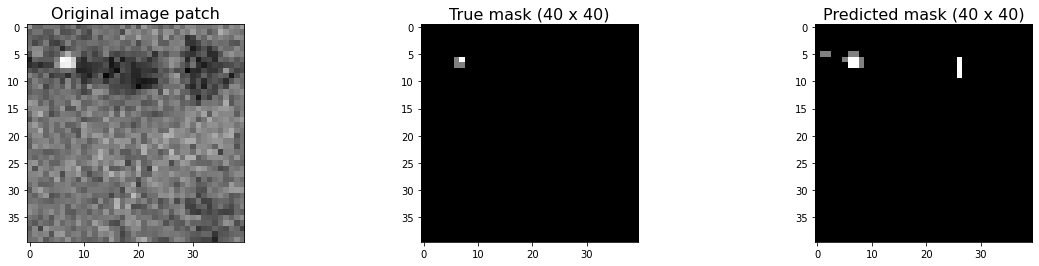

48


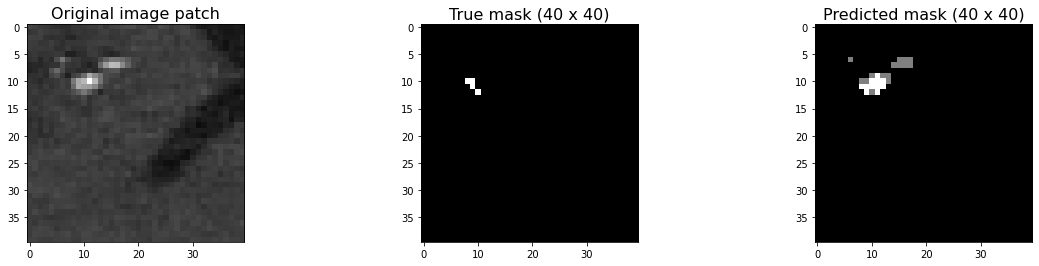

50


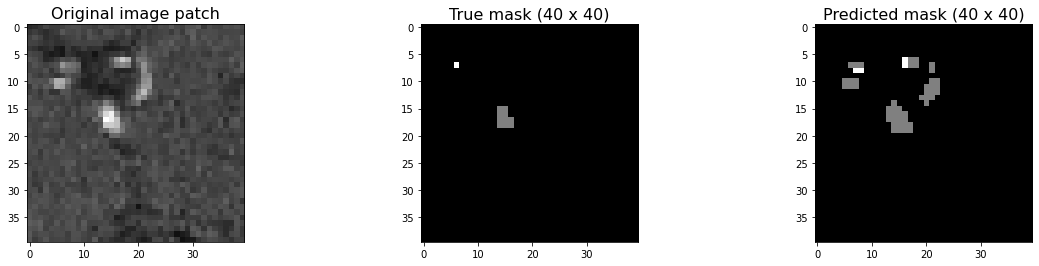

56


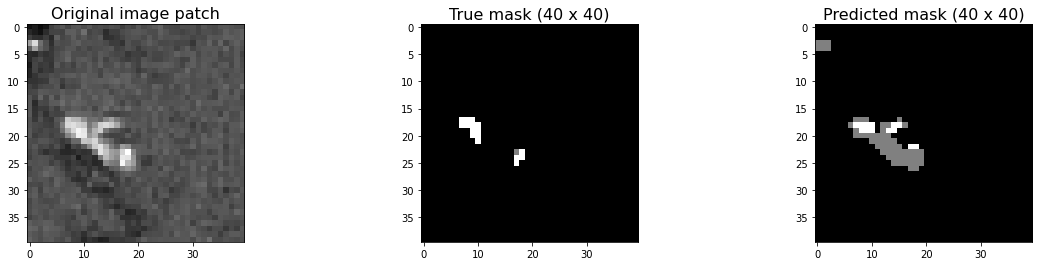

57


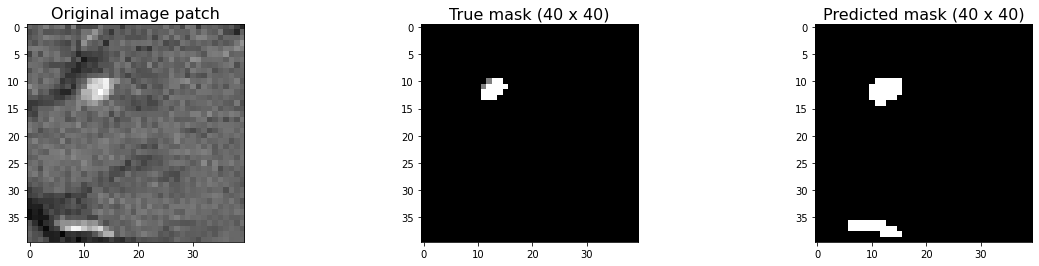

60


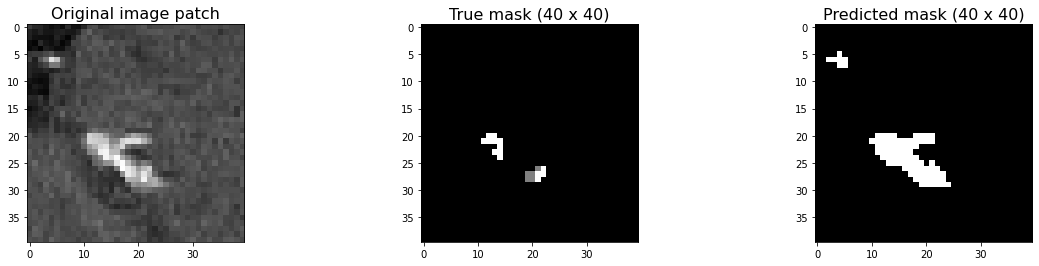

68


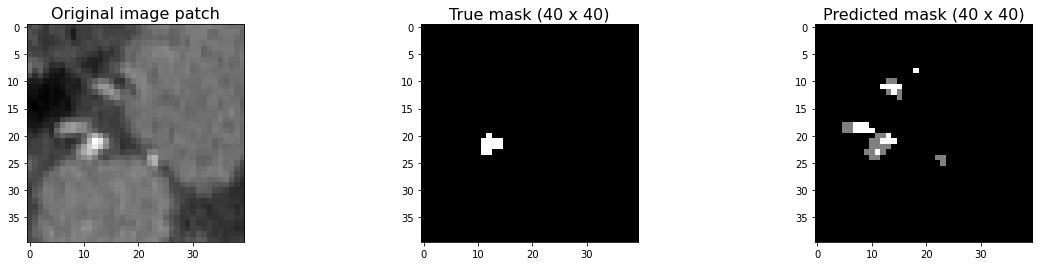

75


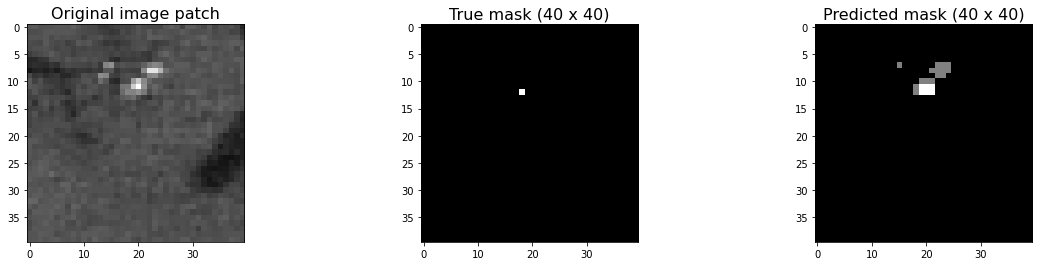

83


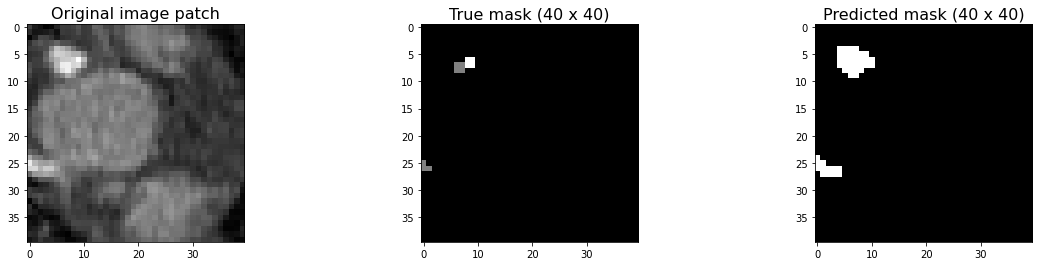

88


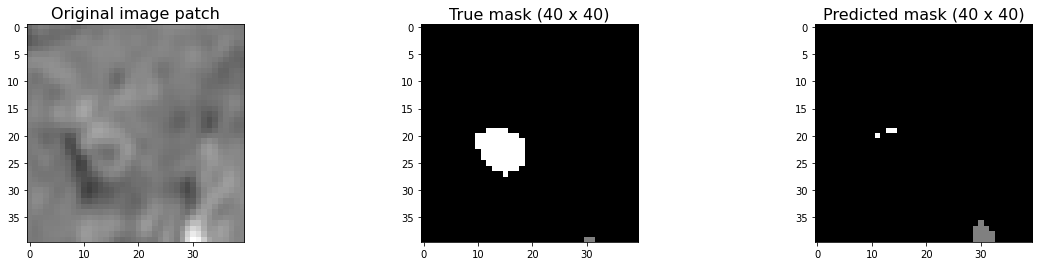

90


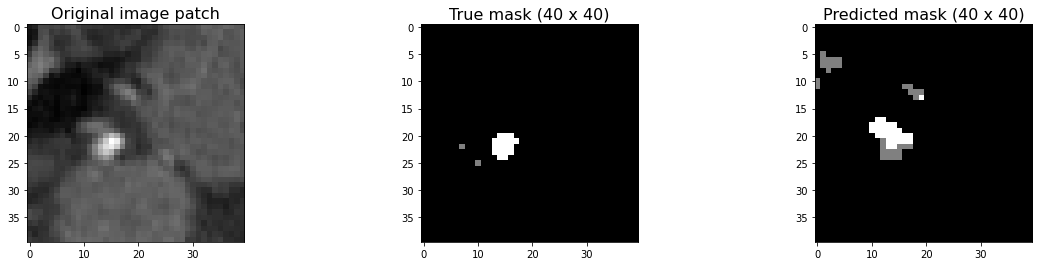

91


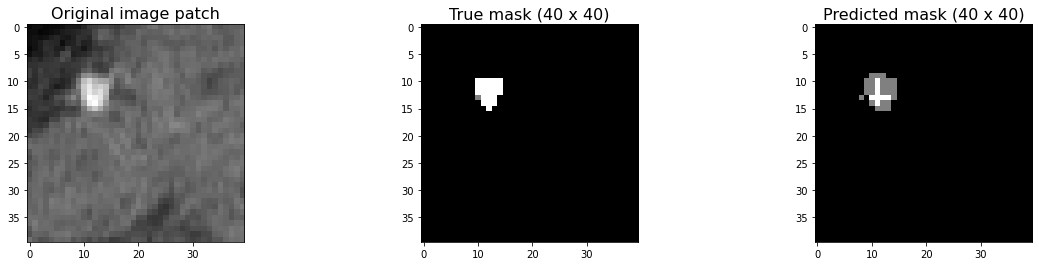

92


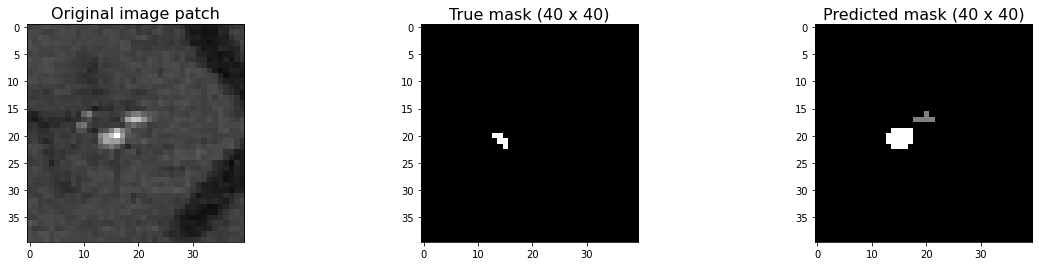

98


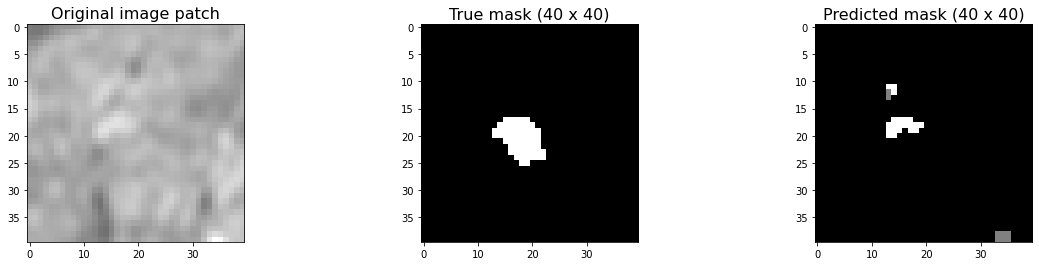

100


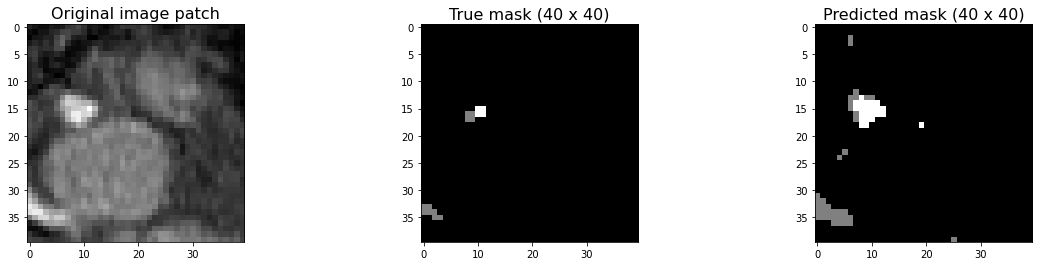

103


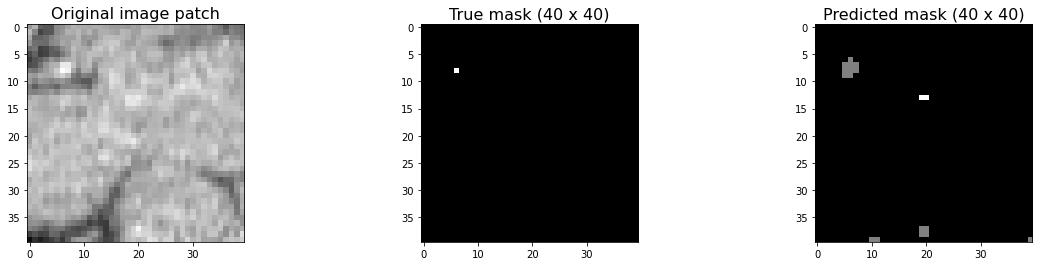

104


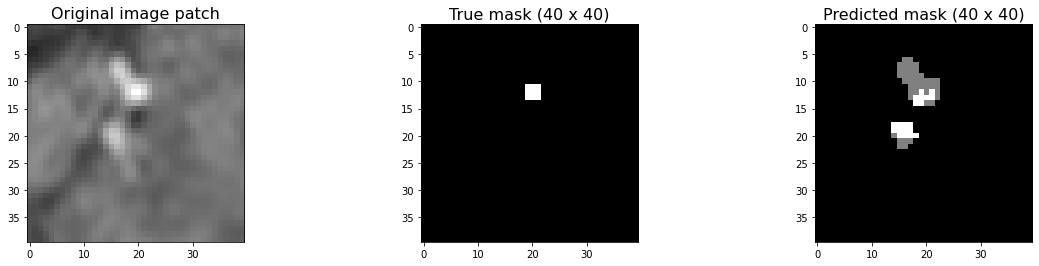

105


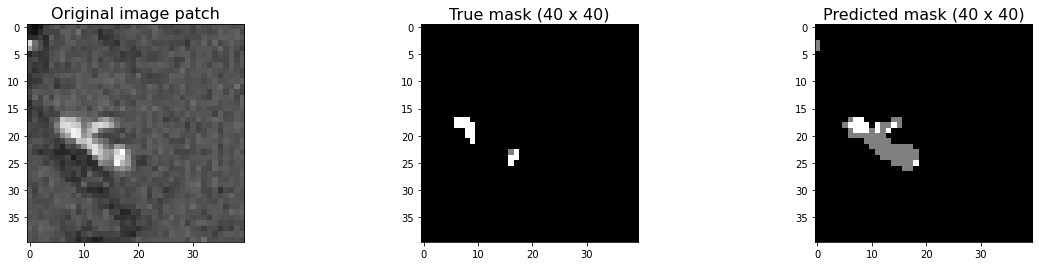

111


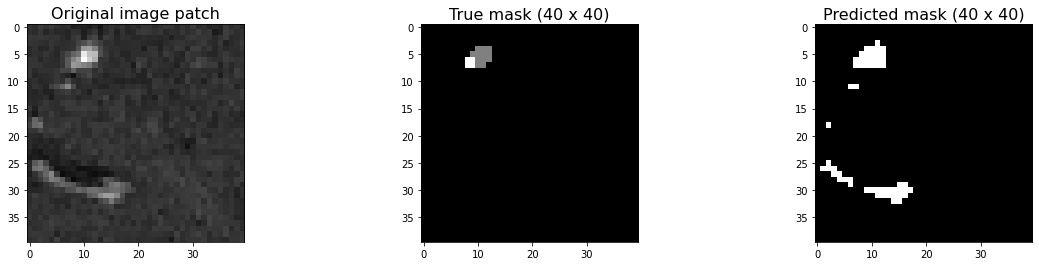

112


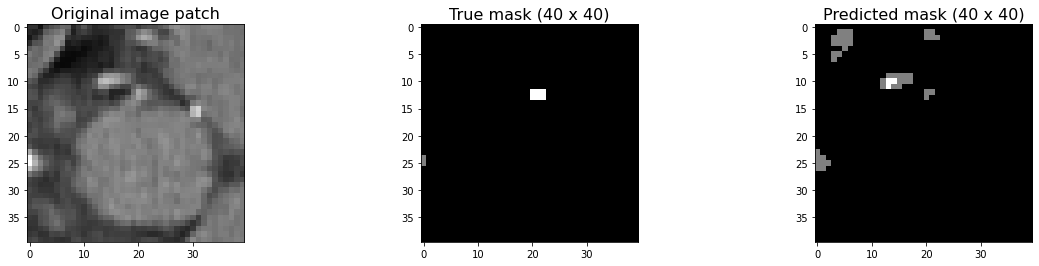

117


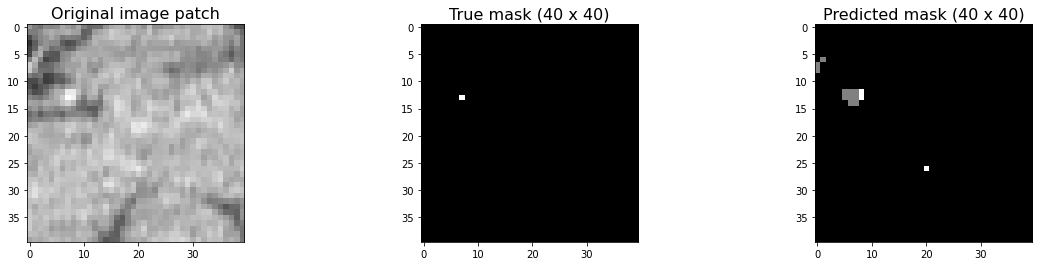

121


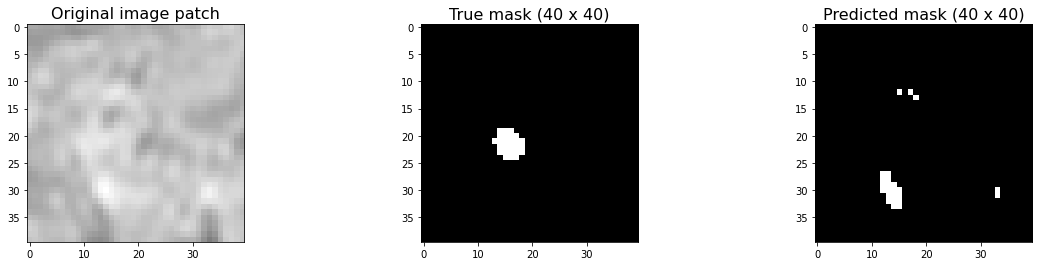

131


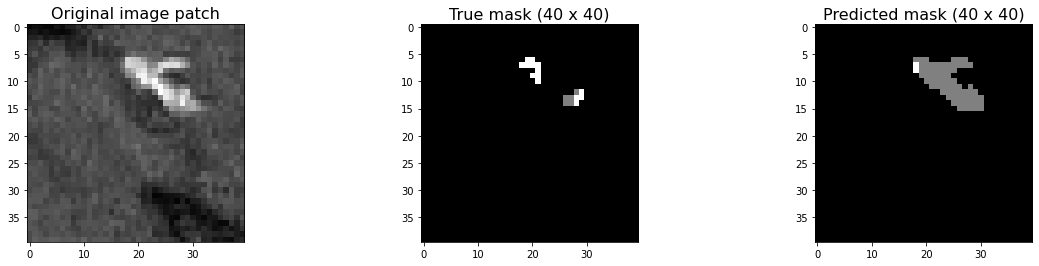

132


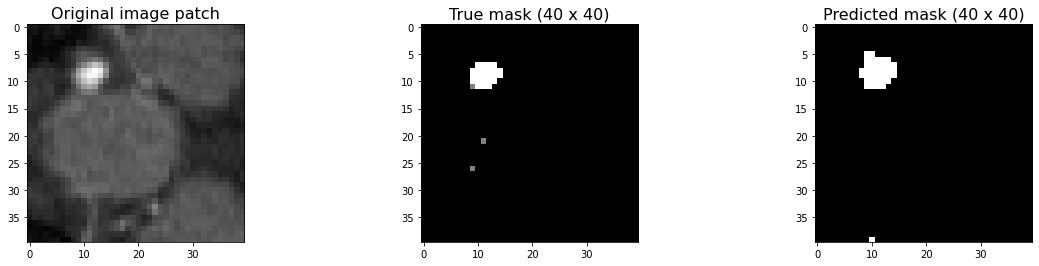

135


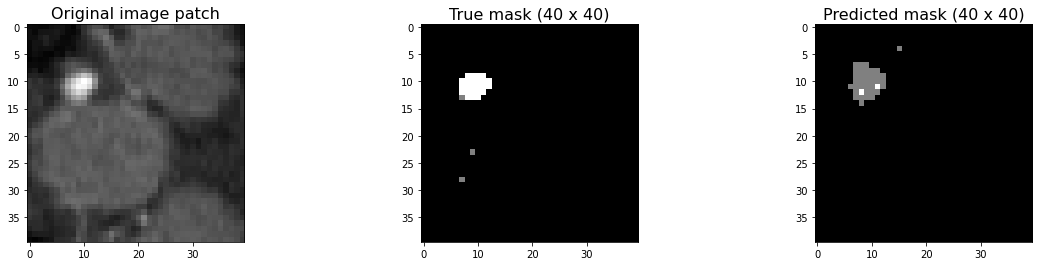

143


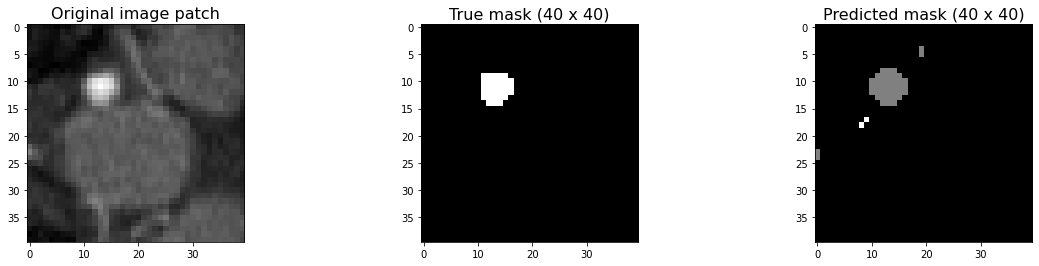

145


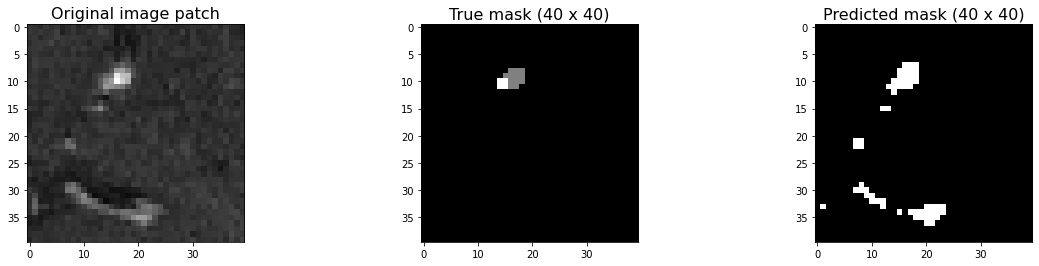

146


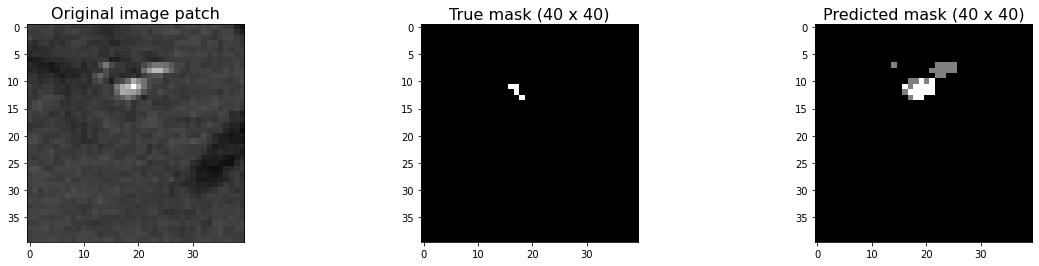

147


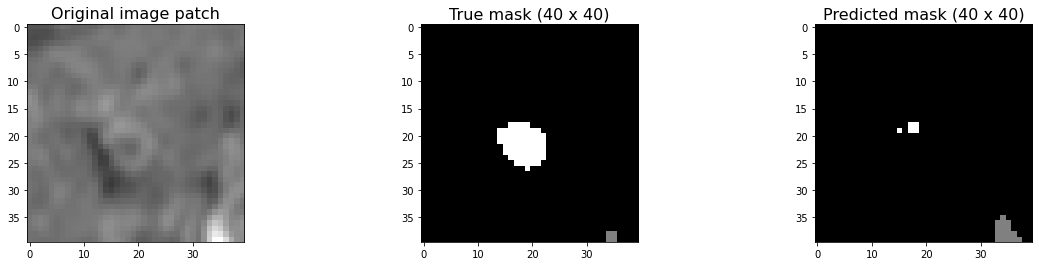

148


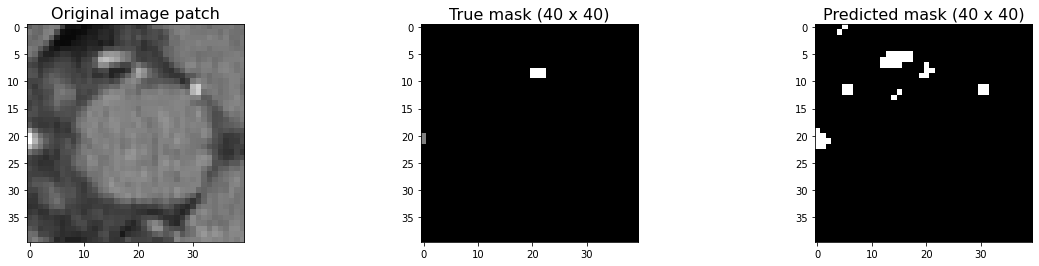

150


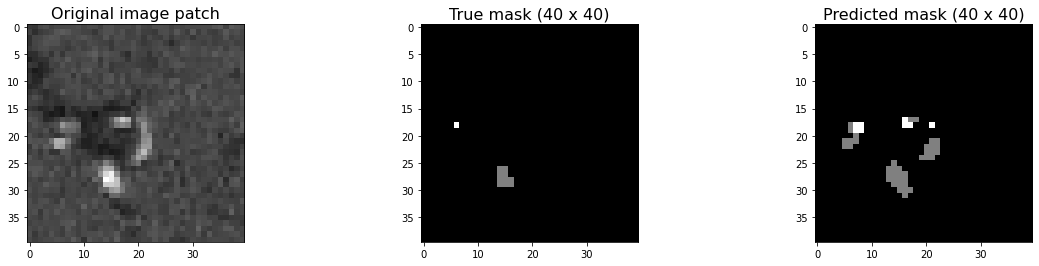

154


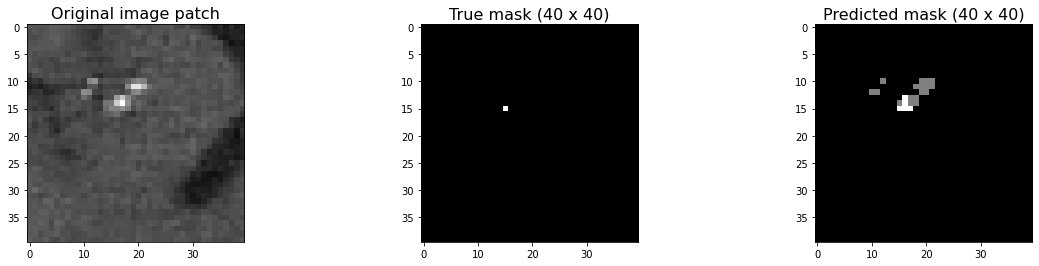

155


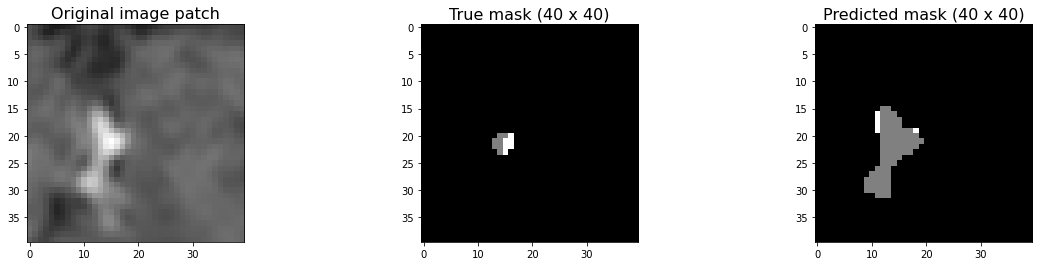

156


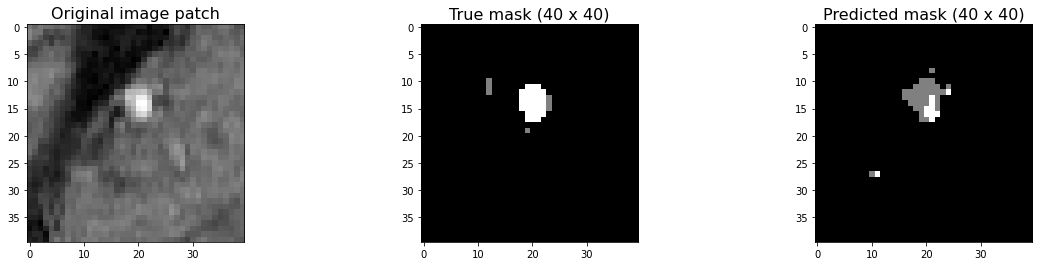

178


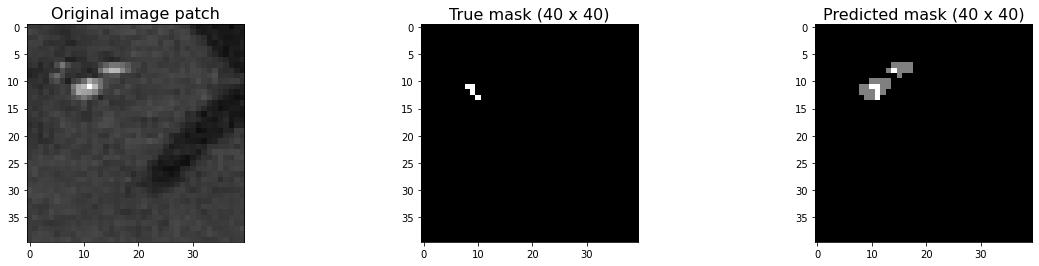

179


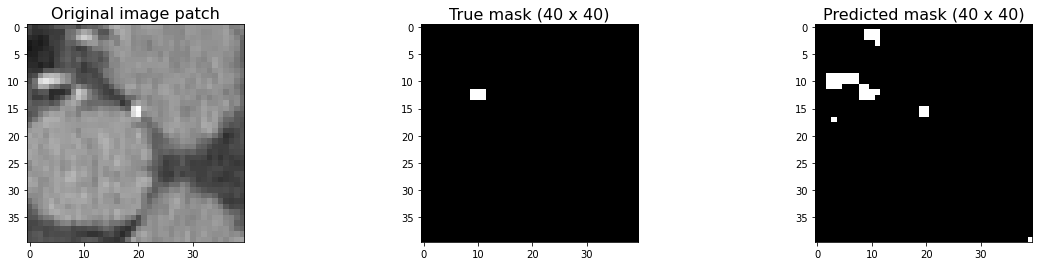

180


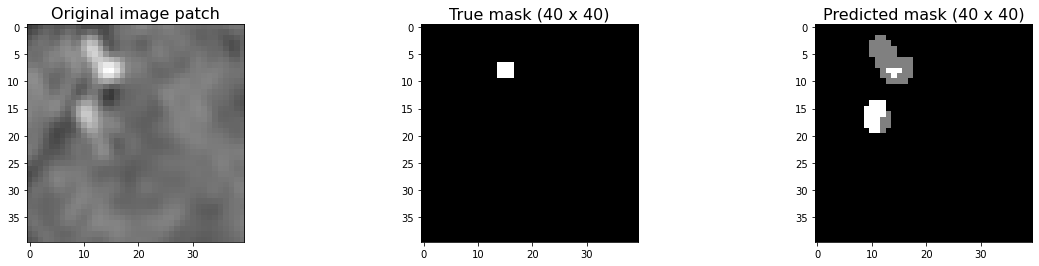

186


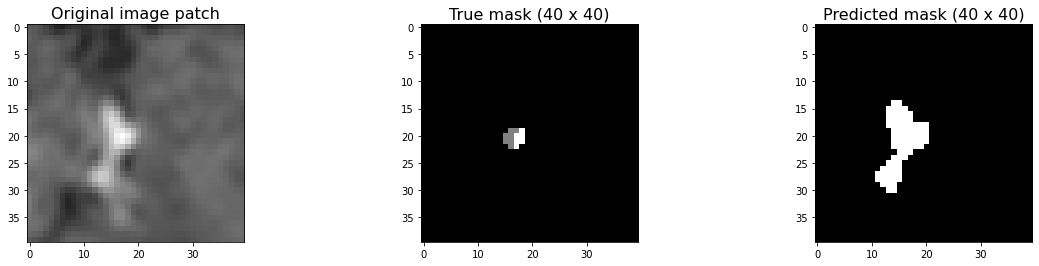

188


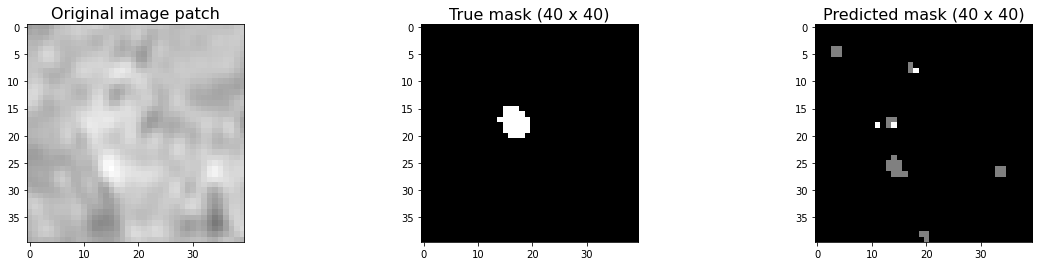

189


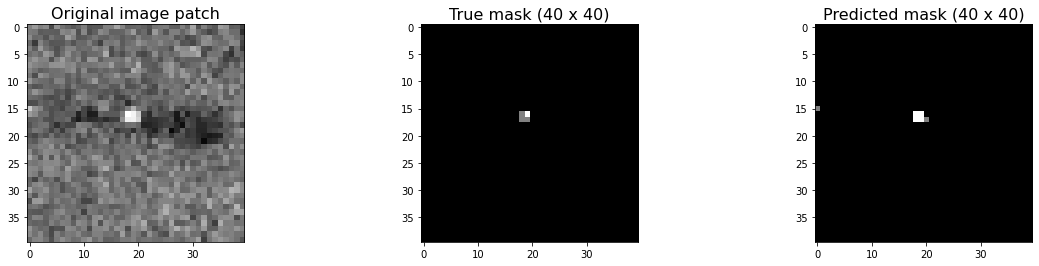

192


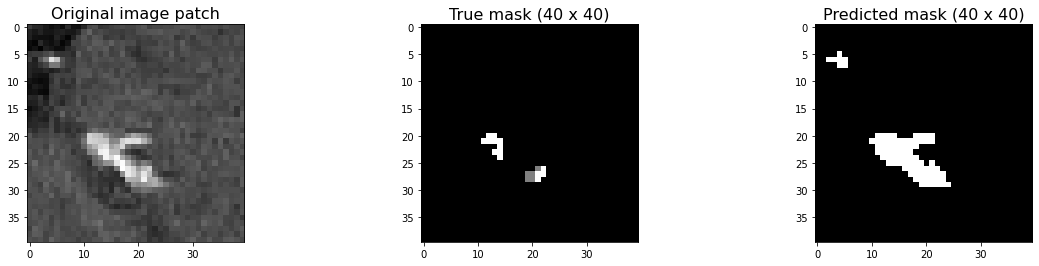

207


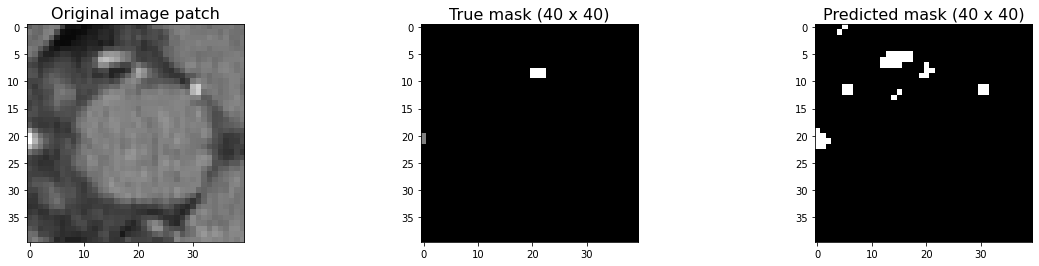

208


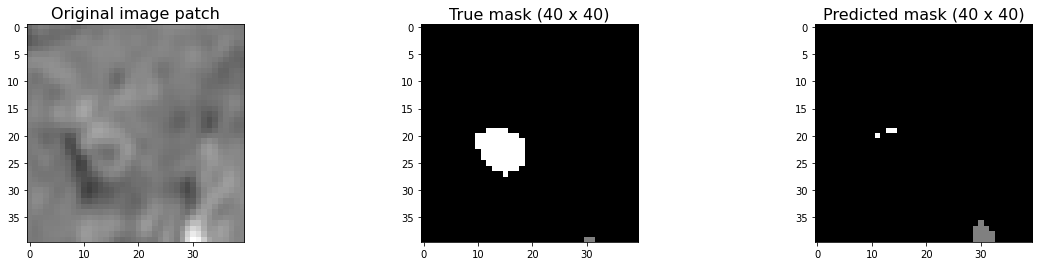

210


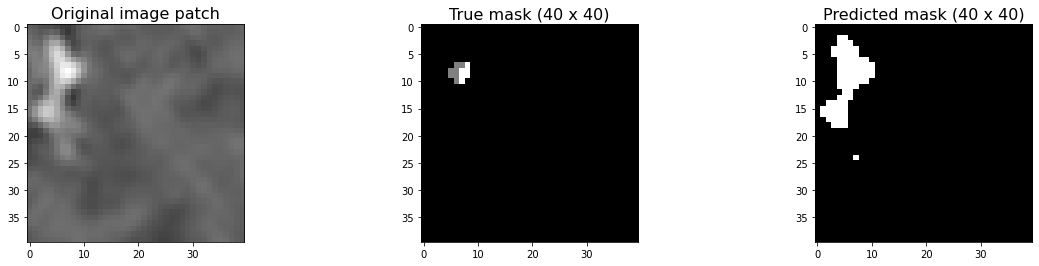

221


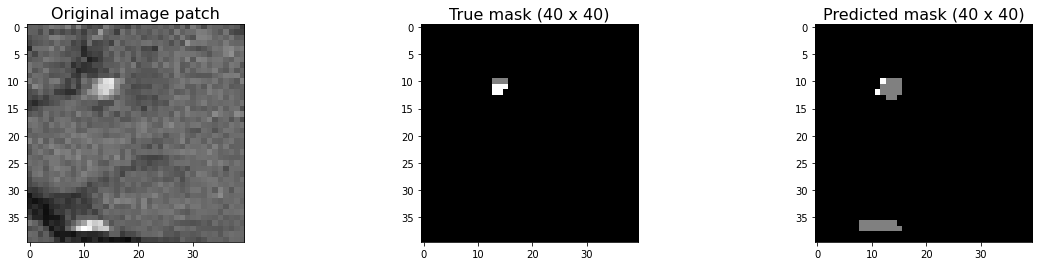

226


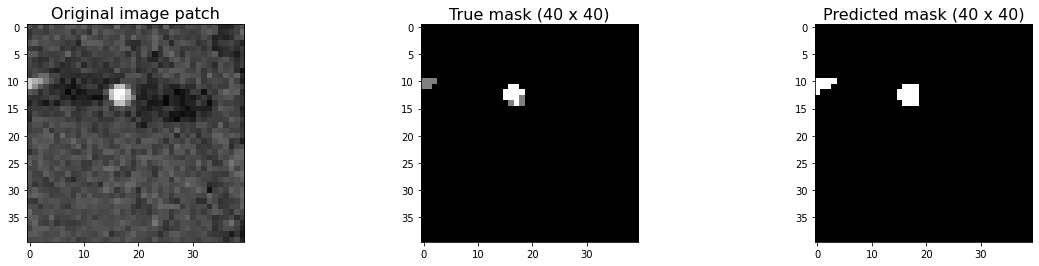

233


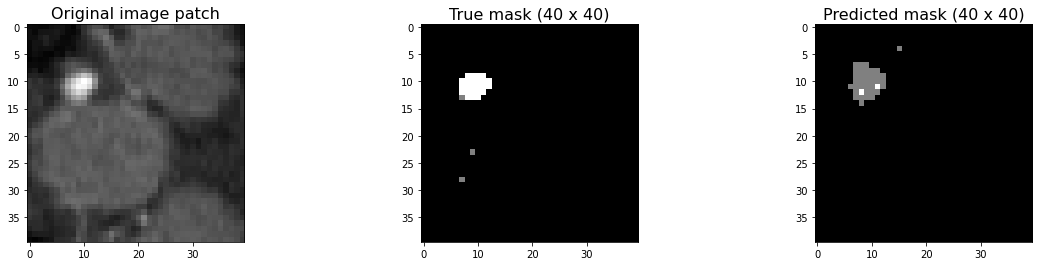

238


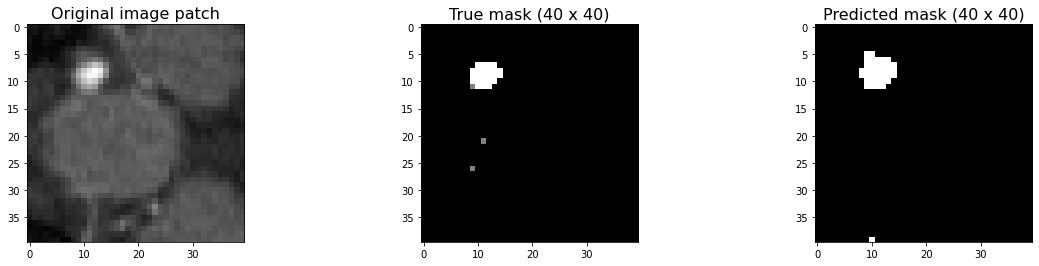

240


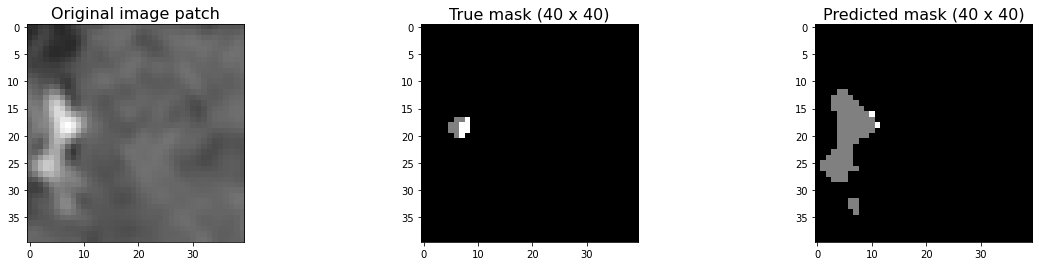

248


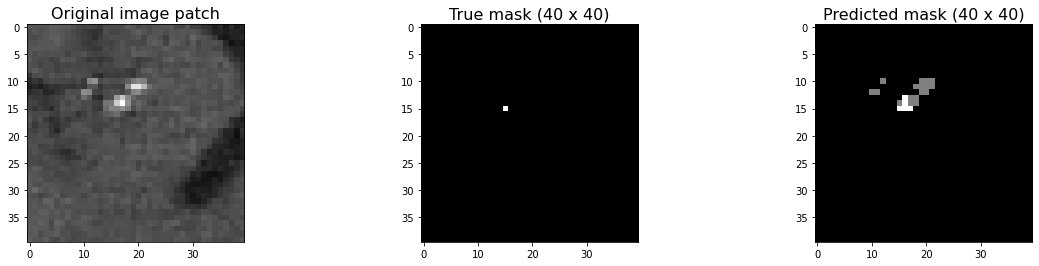

251


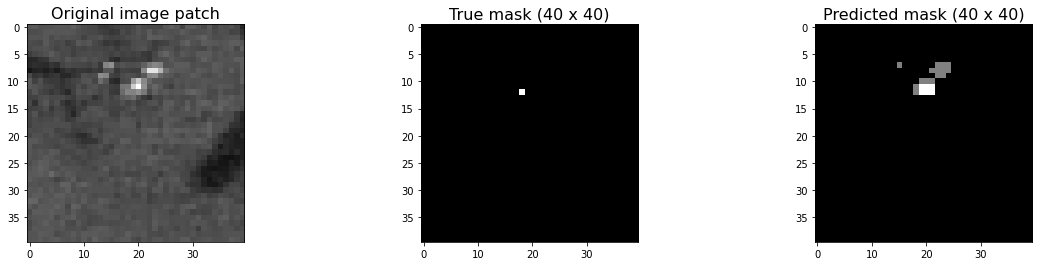

258


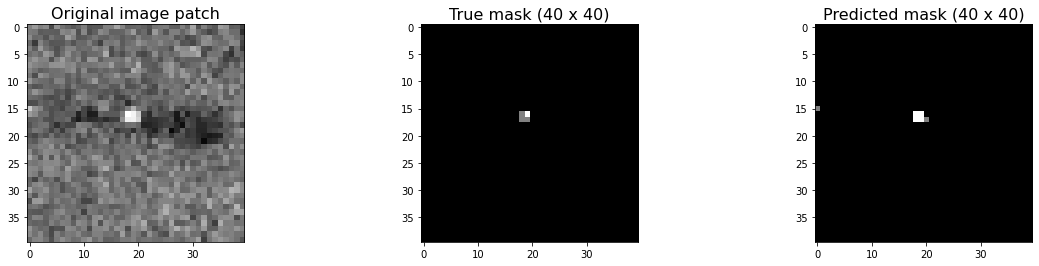

261


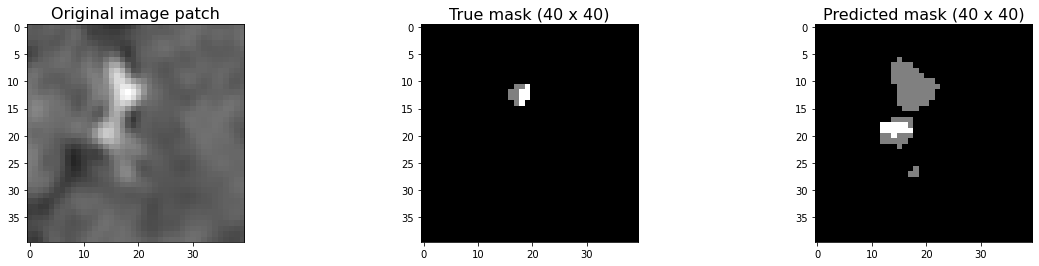

262


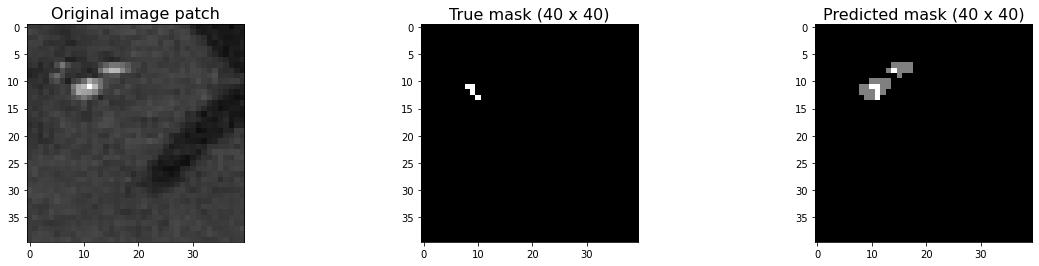

266


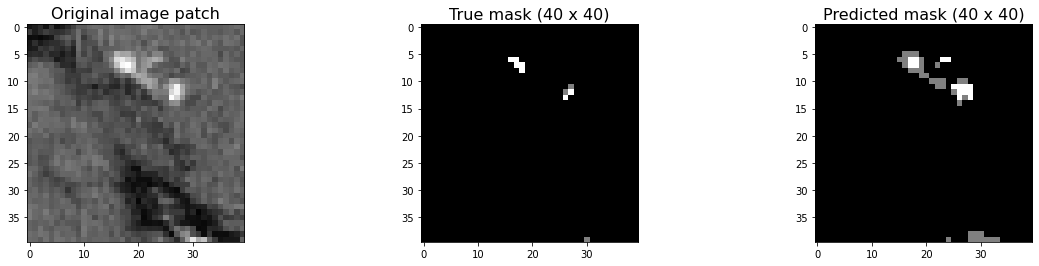

267


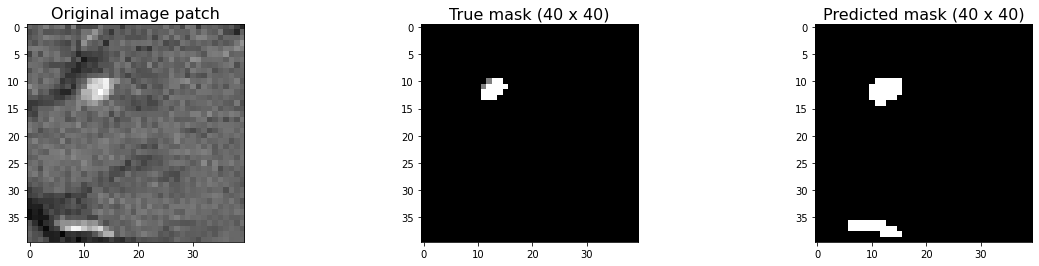

271


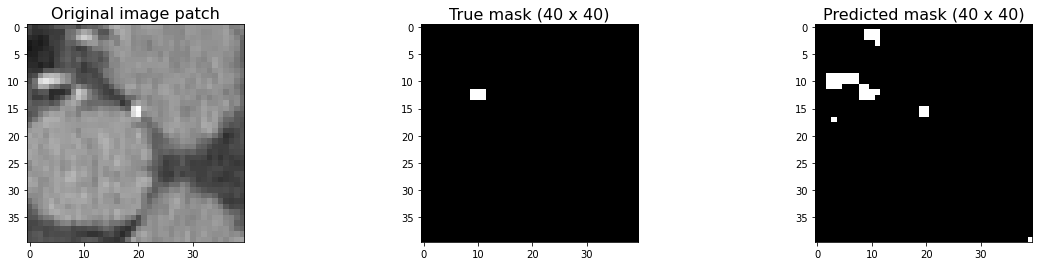

276


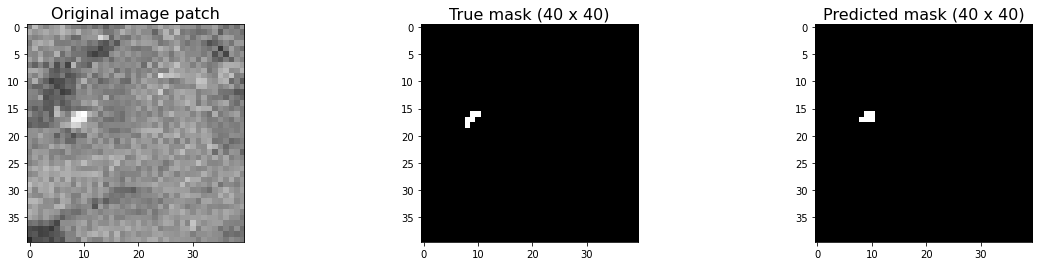

289


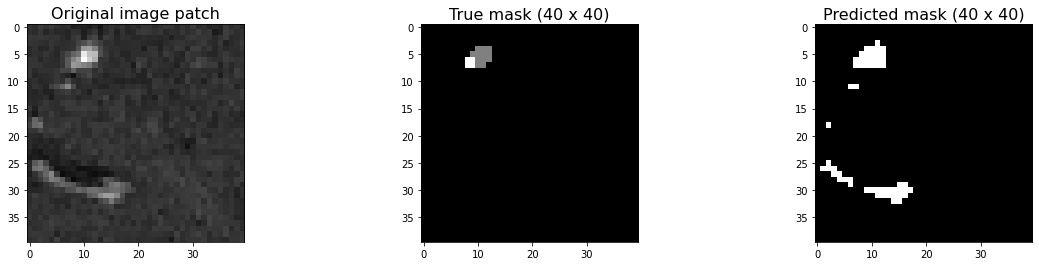

294


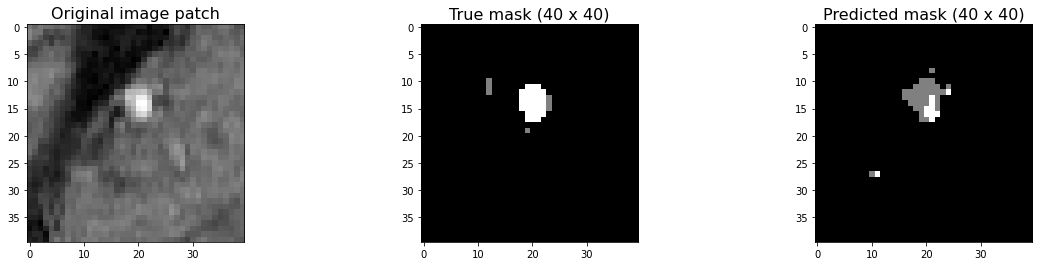

303


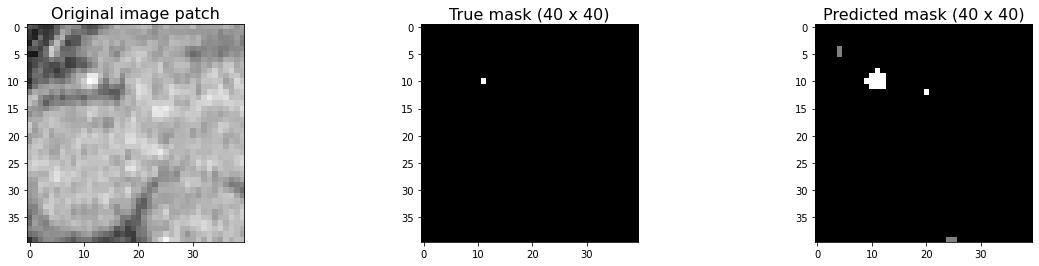

311


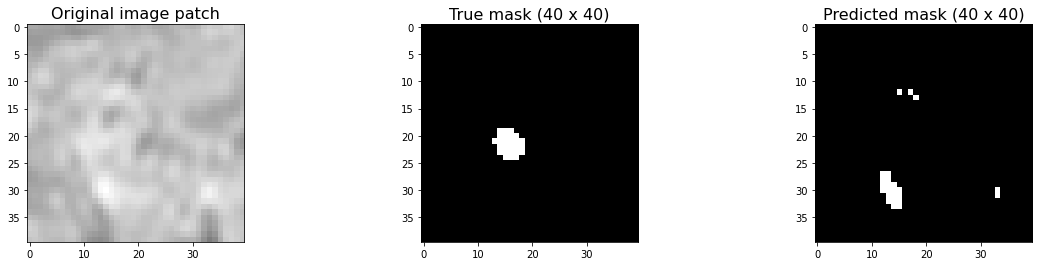

314


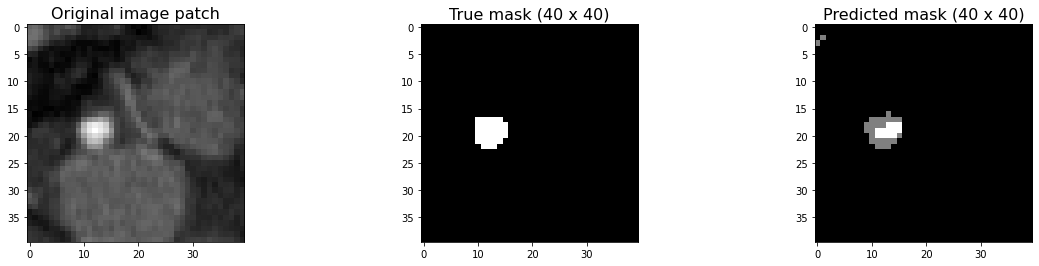

316


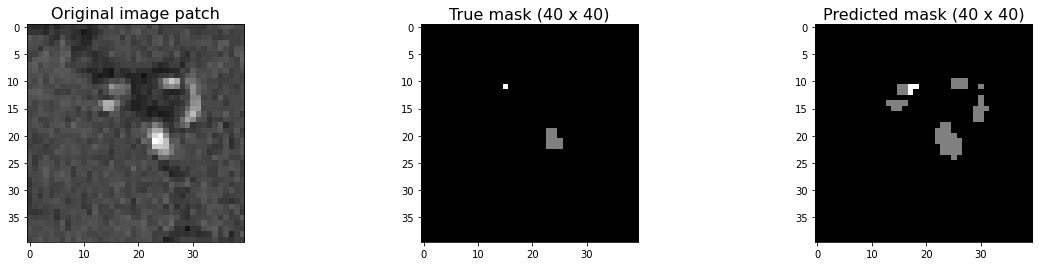

321


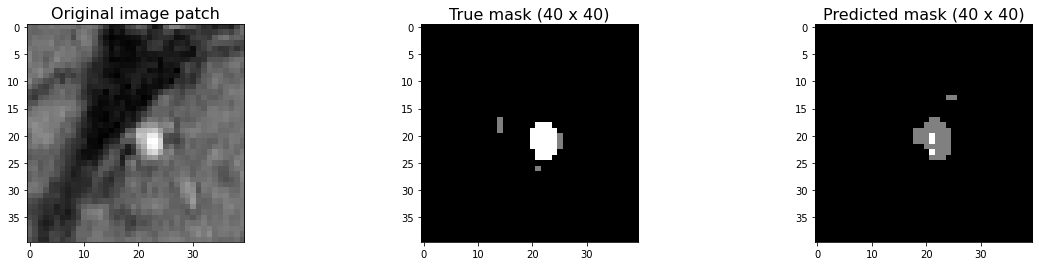

322


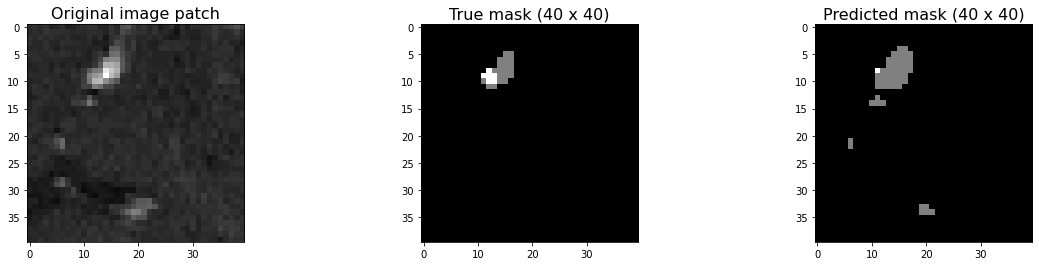

327


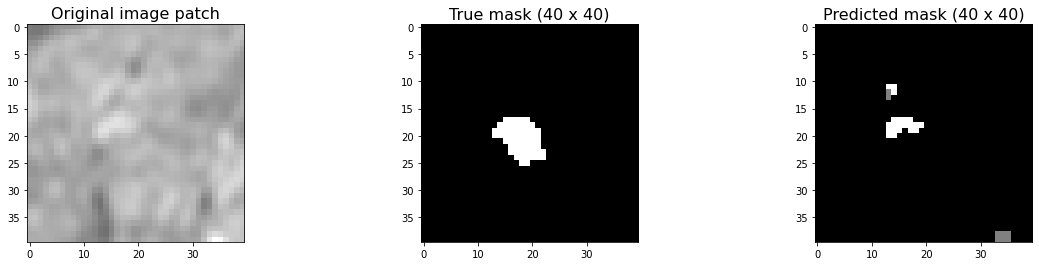

329


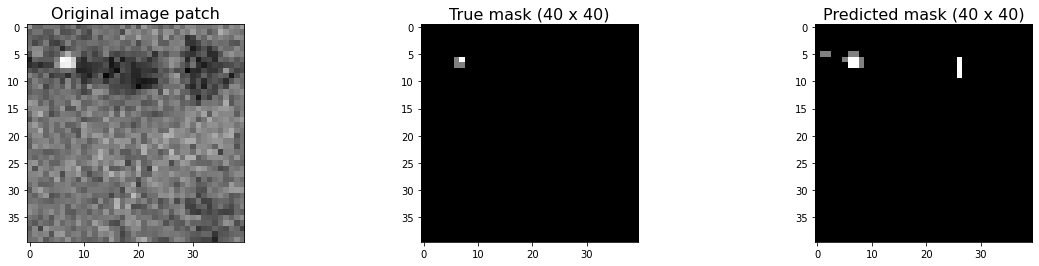

341


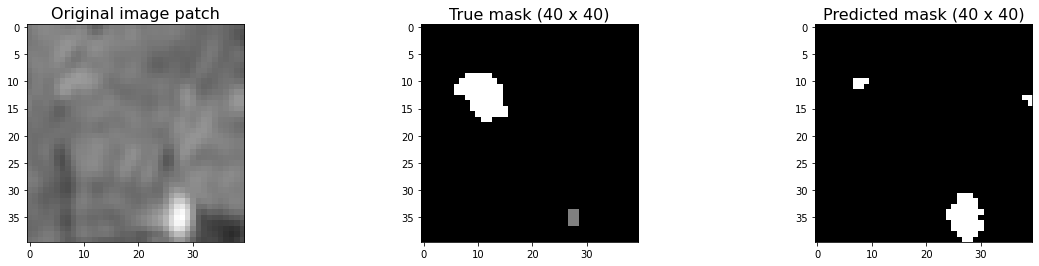

350


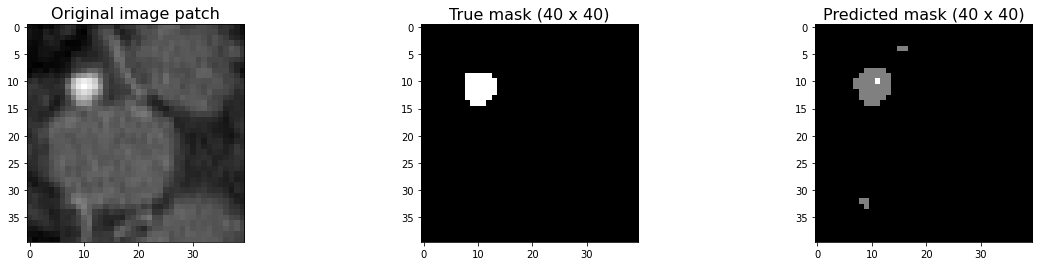

354


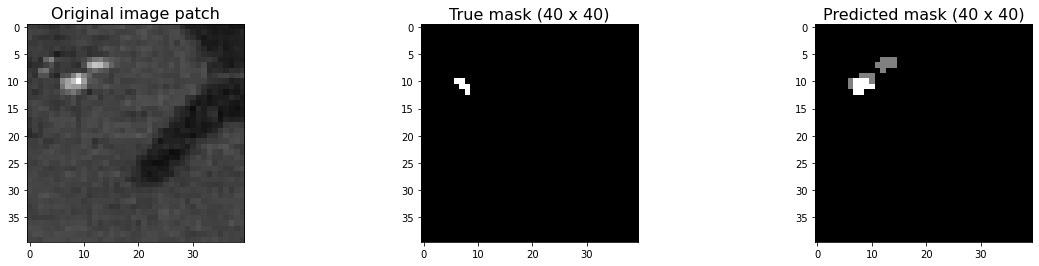

356


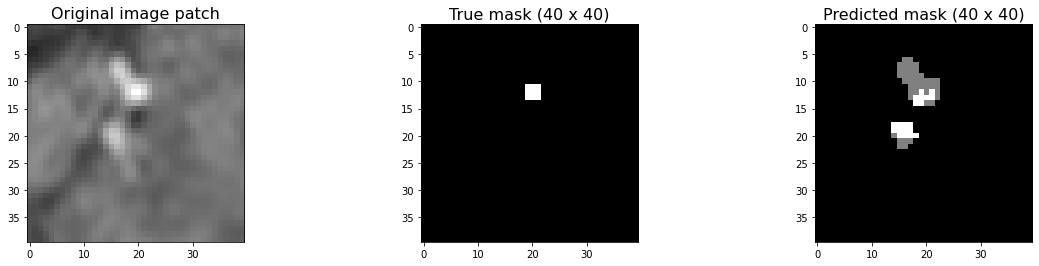

368


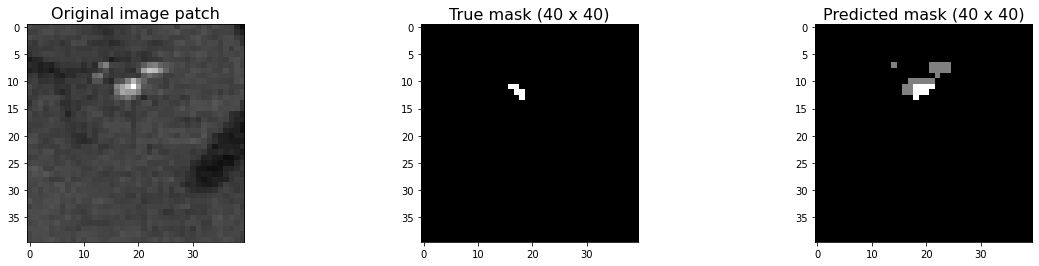

375


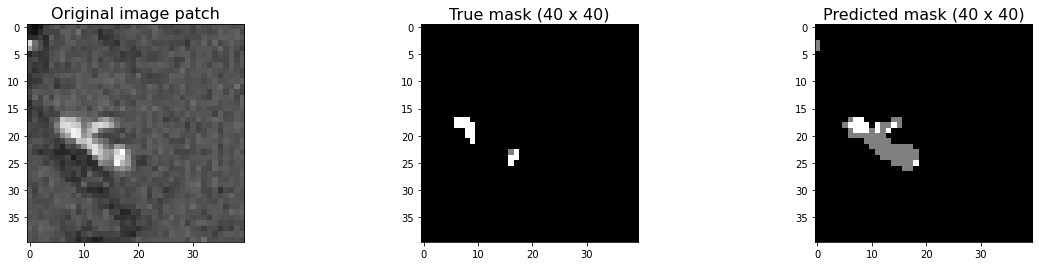

378


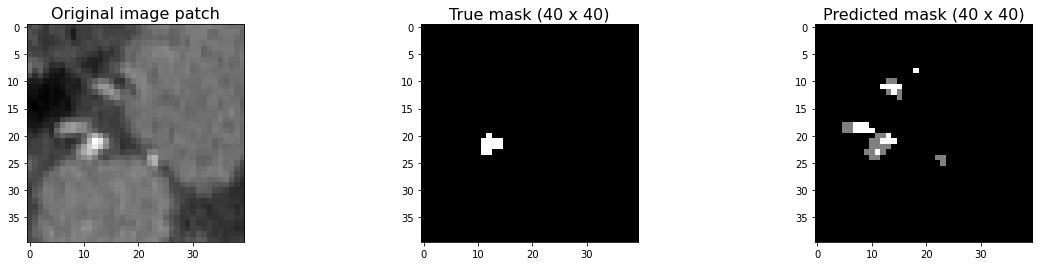

380


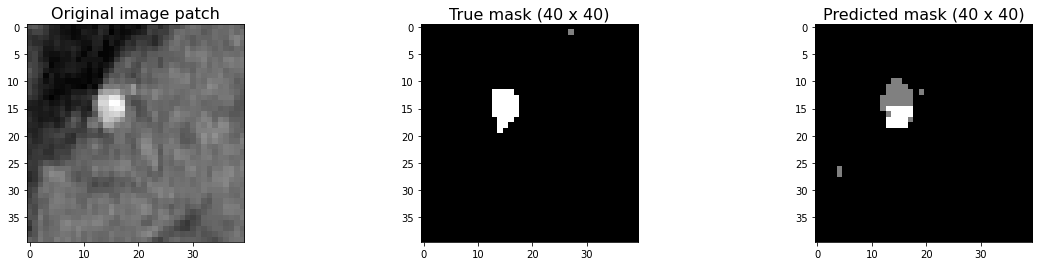

In [ ]:
for i in low:
  print(i)
  compare_img_mask(i)
  plt.show()

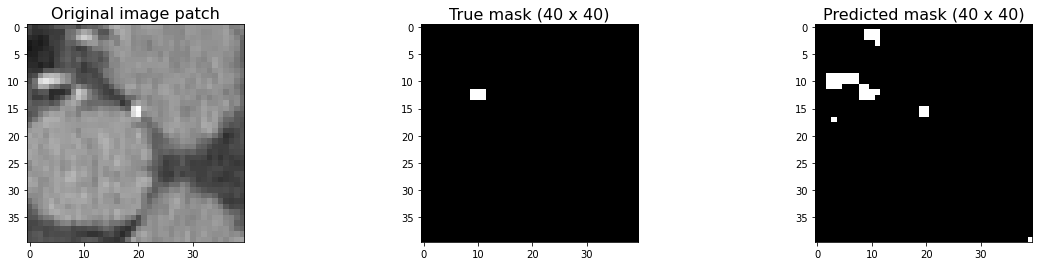

In [ ]:
compare_img_mask(179)

## Hausdorff Distance: aneurysms only


In [ ]:
# calculate hausdorff dist for each pair of true (test_masks) and predicted (test_preds) masks in the test set

hausdorff_list = []
hausdorff_dict = {}

for i in range(len(test_masks)):
  true_mask = test_masks[i]
  pred_mask = test_preds[i]
  a = tf.make_tensor_proto(pred_mask)
  pred_mask = tf.make_ndarray(a)

  hausdorff_dist = directed_hausdorff(true_mask, pred_mask)[0]
  hausdorff_list.append(hausdorff_dist)
  hausdorff_dict[i] = hausdorff_dist

np.mean(hausdorff_list), np.std(hausdorff_list)

(2.32115748837111, 0.9922820906939994)

(0.0, 200.0)

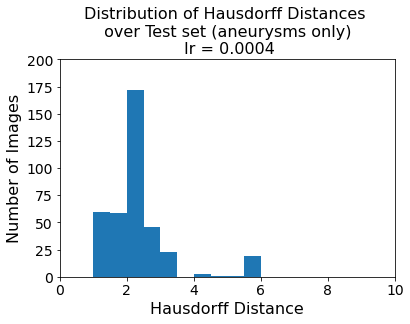

In [ ]:
plt.hist(hausdorff_list)
plt.title('Distribution of Hausdorff Distances \n over Test set (aneurysms only) \n lr = {}'.format(np.round(learning_rate,5)), size=16)
plt.xlabel('Hausdorff Distance', size=16)
plt.ylabel('Number of Images', size=16)
plt.xticks(size=14)
plt.yticks(size=14)

plt.xlim(0, 10)
plt.ylim(0, 200)

In [ ]:
# create lists 'low' and 'high' that store indices of low and high scoring masks respectively

low_h = []
med_h = []
high_h = []

for key,val in hausdorff_dict.items():
  if val<2:
    low_h.append(key)
  elif val<4 and val>2:
    med_h.append(key)
  elif val>4:
    high_h.append(key)

len(low_h), len(med_h), len(high_h)

(134, 162, 30)

In [ ]:
low_h, med_h, high_h

In [ ]:
compare_img_mask(16)

ValueError: ignored

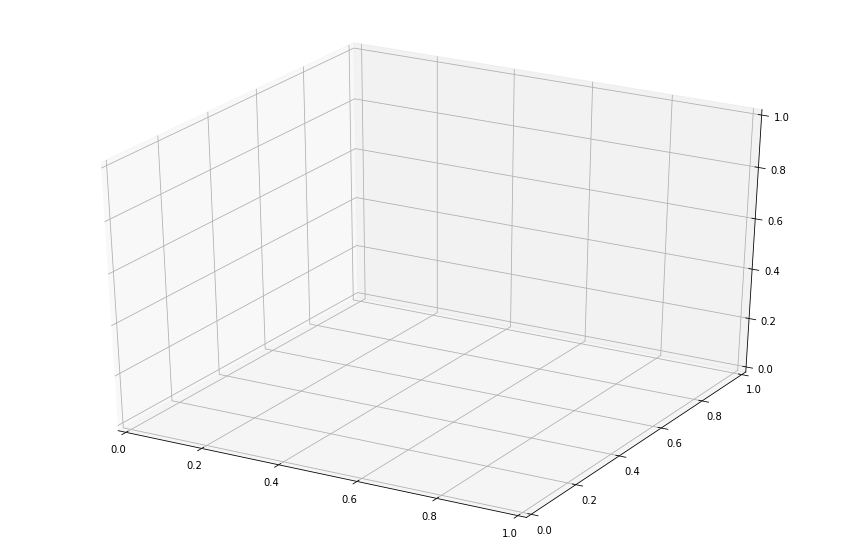

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np

fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(15,10))

# # Make data.
X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
# X, Y = np.meshgrid(X, Y)
# R = np.sqrt(X**2 + Y**2)
# Z = np.sin(R)


# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))


# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

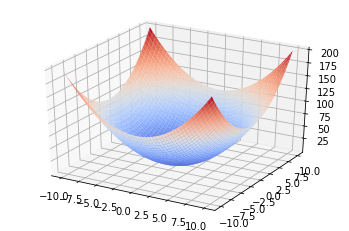

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np

fig = plt.figure()
ax = fig.gca(projection='3d')   # Create the axes

# Data
X = np.linspace(-10, 10, 100)
Y = np.linspace(-10, 10, 100)
X, Y = np.meshgrid(X, Y)
Z = X**2 + Y**2

# Plot the 3d surface
surface = ax.plot_surface(X, Y, Z,
                          cmap=cm.coolwarm,
                          rstride = 2,
                          cstride = 2)


plt.show()